
# EDA de campañas



--EJECUTAR EN TERMINAL 
gcloud auth application-default revoke

gcloud config get-value project

gcloud config get-value project

--Autenticarte con tu cuenta
gcloud auth login

--Configurar el proyecto
gcloud config set project meli-bi-data

Verificar configuración
gcloud config list

Autenticarte para aplicaciones (necesario para Python)
gcloud auth application-default login


In [3]:

import google.auth
from google.cloud import bigquery

creds, project = google.auth.default(scopes=["https://www.googleapis.com/auth/cloud-platform"])
client = bigquery.Client(project=project, credentials=creds)

# Smoke test
client.query("SELECT 1 AS ok", location="US").result()
print("OK")

# Tu query real
query = """
SELECT 1 AS ok
"""
job = client.query(query, location="US")  # <-- location acá
df = job.to_dataframe()

c:\Users\ctattoli\.cursor\.venv\Lib\site-packages\google\auth\_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


OK


In [ ]:

from google.cloud import bigquery_storage

bqstorage_client = bigquery_storage.BigQueryReadClient()
df = job.to_dataframe(bqstorage_client=bqstorage_client)

In [5]:

# =========================
# Configuración del notebook
# =========================
PROJECT    = "meli-bi-data"
LOCATION   = "US"
FULL_NAME  = "`meli-bi-data.WHOWNER.SBOX_SELLERSMP.CT_VIEWS_TIENDA`"  # tabla/vista fuente

# Rango de fechas (half-open): [DATE_START, DATE_END)
DATE_START = "2025-06-01"   # inclusive
DATE_END   = "2025-07-01"   # exclusivo (equivale a <= 2025-06-30)

# Carpeta local para exports
OUT_DIR    = "./eda_outputs"


In [ ]:

# =========================
# Imports y cliente BigQuery
# =========================
import os, warnings
os.makedirs(OUT_DIR, exist_ok=True)
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({"figure.figsize": (10, 4), "axes.grid": True})

import google.auth
from google.cloud import bigquery

SCOPES = ["https://www.googleapis.com/auth/cloud-platform"]
creds, _ = google.auth.default(scopes=SCOPES)
bq = bigquery.Client(project=PROJECT, credentials=creds, location=LOCATION)


try:
    from google.cloud import bigquery_storage
    bqstorage_client = bigquery_storage.BigQueryReadClient(credentials=creds)
except Exception:
    bqstorage_client = None

print("✅ Cliente BigQuery listo. Proyecto de billing:", bq.project)


✅ Cliente BigQuery listo. Proyecto de billing: meli-bi-data


In [ ]:

# =========================
# Helpers
# =========================
from typing import List

def dry_run_bytes(sql: str, params=None) -> int:
    cfg = bigquery.QueryJobConfig(dry_run=True, use_query_cache=False,
                                  query_parameters=params or [])
    job = bq.query(sql, job_config=cfg)
    return job.total_bytes_processed

def run_df(sql: str, params=None) -> pd.DataFrame:
    params = params or []
    print(f"Bytes (dry run): {dry_run_bytes(sql, params):,}")
    job_cfg = bigquery.QueryJobConfig(query_parameters=params)
    return bq.query(sql, job_config=job_cfg).to_dataframe(bqstorage_client=bqstorage_client)

BQ_PARAMS = [
    bigquery.ScalarQueryParameter("date_start","DATE", DATE_START),
    bigquery.ScalarQueryParameter("date_end","DATE",   DATE_END),
]


## SQL base: dedup + features

In [ ]:

print("BQ_PARAMS contiene:", BQ_PARAMS)
print("Tipo de BQ_PARAMS:", type(BQ_PARAMS))


if 'BQ_PARAMS' not in locals() or BQ_PARAMS is None:
    from google.cloud import bigquery
    
    BQ_PARAMS = [
        bigquery.ScalarQueryParameter("date_start", "DATE", "2025-06-01"),
        bigquery.ScalarQueryParameter("date_end", "DATE", "2025-07-01")
    ]
    print("BQ_PARAMS creado:", BQ_PARAMS)

BQ_PARAMS contiene: [ScalarQueryParameter('date_start', 'DATE', '2025-06-01'), ScalarQueryParameter('date_end', 'DATE', '2025-07-01')]
Tipo de BQ_PARAMS: <class 'list'>


In [9]:

SQL_BASE = f"""

  SELECT *
    /*t.PHOTO_DATE,
    t.CUS_CUST_ID,
    t.ITE_ITEM_ID,
    t.SI,
    t.GRUPO,
    t.GMV_USD,
    t.GMV_USD_CON_VC_UE,
    t.QTY_ORDERS,
    t.ACTUAL_PRICE,
    t.ORIGINAL_PRICE,
    t.PROMOTION_DISCOUNT_PCT,
    t.COUPON_STATUS,
    t.COUPON_PCT_DISCOUNT,
    --t.COUPON_MAX_DISCOUNT,
    t.VERTICAL,
    t.PLATFORM,
    --t.LISTING_TYPE,
    --t.LOGISTIC_TYPE,
    t.INSTALLMENTS,
    t.POWER_SELLER_STATUS,
    t.REPUTATION_LEVEL,
    --t.ORDER_LIST_DOMAIN,
    --t.DOM_DOMAIN_AGG1,
    t.DOM_DOMAIN_AGG2,
    t.DOM_DOMAIN_AGG3,
    --t.ORD_CREATED_DTTM_MAX,
    --t.FIRST_SEEN_DTTM,
    t.IS_FREE_INSTALLMENTS,
    t.FREE_SHIPPING,
    t.HIGHLIGHT_ID, 
    t.genero, 
    t.rango_edad,
    ROW_NUMBER() OVER (
      PARTITION BY t.PHOTO_DATE, t.CUS_CUST_ID, t.ITE_ITEM_ID
      --ORDER BY t.ORD_CREATED_DTTM_MAX DESC, t.FIRST_SEEN_DTTM DESC
    ) AS rn*/
  FROM meli-bi-data.SBOX_SELLERSMP.CT_VIEWS_TIENDA AS t
  WHERE t.PHOTO_DATE >= @date_start
    AND t.PHOTO_DATE <  @date_end
    AND 
    t.GRUPO IN ('TEST','CONTROL')
;
"""

n = dry_run_bytes(SQL_BASE, BQ_PARAMS)

print(f"Dry-run: {n:,} bytes "
      f"≈ {n/1_000_000_000:.2f} GB (decimal) "
      )





Dry-run: 11,557,306,036 bytes ≈ 11.56 GB (decimal) 


In [ ]:
#REDUCCIÓN DE DIMENSIONALIDAD

# =========================
# Config
# =========================
PROJECT   = "meli-bi-data"
LOCATION  = "US"
TABLE_FULL = "`meli-bi-data.SBOX_SELLERSMP.CT_VIEWS_TIENDA`"  # ajustá si tu ruta es distinta

DATE_START = "2025-06-01"   # inclusive
DATE_END   = "2025-07-01"   # exclusivo (equivale a <= 2025-06-30)
PCT_USERS  = 30            

USE_TABLESAMPLE   = True    
TABLESAMPLE_PCT   = 30      # % de bloques físicos (literal, no parámetro)
TABLESAMPLE_SEED  = 123     # semilla de repetibilidad

# =========================
# Cliente y helpers
# =========================
import google.auth
from google.cloud import bigquery
import pandas as pd
from pathlib import Path

SCOPES = ["https://www.googleapis.com/auth/cloud-platform"]
creds, _ = google.auth.default(scopes=SCOPES)
client = bigquery.Client(project=PROJECT, credentials=creds, location=LOCATION)

try:
    from google.cloud import bigquery_storage
    bqstorage_client = bigquery_storage.BigQueryReadClient(credentials=creds)
except Exception:
    bqstorage_client = None

def human_bytes(n):
    for unit in ["B","KB","MB","GB","TB"]:
        if n < 1024: return f"{n:.2f} {unit}"
        n /= 1024
    return f"{n:.2f} PB"

# =========================
# SQL integrada (1 + 2)
# =========================
TABLESAMPLE_CLAUSE = (
    f"TABLESAMPLE SYSTEM ({TABLESAMPLE_PCT} PERCENT) "
    if USE_TABLESAMPLE else ""
)

SQL = f"""
WITH sampled AS (
  SELECT *
  FROM {TABLE_FULL}
  {TABLESAMPLE_CLAUSE}
),
base AS (
     
  SELECT
    t.PHOTO_DATE,
    t.CUS_CUST_ID,
    t.ITE_ITEM_ID,
    t.SI,
    t.GRUPO,
    t.GMV_USD,
    t.GMV_USD_CON_VC_UE,
    t.QTY_ORDERS,
    t.ACTUAL_PRICE,
    t.ORIGINAL_PRICE,
    t.PROMOTION_DISCOUNT_PCT,
    t.COUPON_STATUS,
    t.COUPON_PCT_DISCOUNT,
    --t.COUPON_MAX_DISCOUNT,
    t.VERTICAL,
    t.PLATFORM,
    --t.LISTING_TYPE,
    --t.LOGISTIC_TYPE,
    t.INSTALLMENTS,
    t.POWER_SELLER_STATUS,
    t.REPUTATION_LEVEL,
    --t.ORDER_LIST_DOMAIN,
    --t.DOM_DOMAIN_AGG1,
    t.DOM_DOMAIN_AGG2,
    t.DOM_DOMAIN_AGG3,
    --t.ORD_CREATED_DTTM_MAX,
    --t.FIRST_SEEN_DTTM,
    t.IS_FREE_INSTALLMENTS,
    t.FREE_SHIPPING,
    t.HIGHLIGHT_ID, 
    t.genero, 
    t.rango_edad,
    ROW_NUMBER() OVER (
      PARTITION BY t.PHOTO_DATE, t.CUS_CUST_ID, t.ITE_ITEM_ID
    ) AS rn
  FROM sampled AS t
  WHERE t.PHOTO_DATE >= @date_start
    AND t.PHOTO_DATE <  @date_end
    AND t.GRUPO IN ('TEST','CONTROL')
    -- Muestreo estable por usuario (preserva balance T/C y es reproducible)
    AND MOD(ABS(FARM_FINGERPRINT(CAST(t.CUS_CUST_ID AS STRING))), 100) < @pct
)
SELECT *
FROM base
WHERE rn = 1
"""

params = [
    bigquery.ScalarQueryParameter("date_start","DATE", DATE_START),
    bigquery.ScalarQueryParameter("date_end","DATE",   DATE_END),
    bigquery.ScalarQueryParameter("pct","INT64",       PCT_USERS),
]

# =========================
# Dry run de bytes
# =========================
dry_cfg = bigquery.QueryJobConfig(dry_run=True, use_query_cache=False, query_parameters=params)
dry_job = client.query(SQL, job_config=dry_cfg)
print("Dry-run:", human_bytes(dry_job.total_bytes_processed))

# ===========
# Ejecución 
# ===========


df = client.query(SQL, job_config=bigquery.QueryJobConfig(query_parameters=params)).to_dataframe(
        bqstorage_client=bqstorage_client
)
print("Shape DF:", df.shape)


print(df["GRUPO"].value_counts(dropna=False))


c:\Users\ctattoli\.cursor\.venv\Lib\site-packages\google\auth\_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Dry-run: 1.74 GB
Shape DF: (3262922, 26)
GRUPO
TEST       2978954
CONTROL     283968
Name: count, dtype: int64


In [ ]:
# N minimo para representatividad

import math

def n_for_prop(p=0.05, eps=0.0025, z=2.58, N=None, deff=1.0):
    """Tamaño muestral para una proporción con (opcional) corrección por población finita y design effect."""
    n0 = (z**2 * p * (1-p)) / (eps**2)           # Cochran (población infinita)
    n0 *= deff                                   # efecto de diseño (clusters/estratos)
    if not N:                                    # sin FPC
        return math.ceil(n0)
    n = n0 / (1 + (n0 - 1) / N)                  # FPC
    return math.ceil(n)

print("n0 infinita:", n_for_prop(0.05, 0.0025, 2.58))
print("N con FPC:", n_for_prop(0.05, 0.0025, 2.58, N=36_412_218))
print("N + diseño (DEFF=1.2):", n_for_prop(0.05, 0.0025, 2.58, N=36_412_218, deff=1.2))


n0 infinita: 50589
N con FPC: 50519
N + diseño (DEFF=1.2): 60606


Testeo de representatividad

In [ ]:
from google.cloud import bigquery

DATE_START = "2025-06-01"; DATE_END = "2025-07-01"
TABLE_FULL = "`meli-bi-data.SBOX_SELLERSMP.CT_VIEWS_TIENDA`"
PCT = 30  

sql_pop = f"""
SELECT
  PHOTO_DATE, CUS_CUST_ID, ITE_ITEM_ID, GRUPO,
  GMV_USD, QTY_ORDERS, ACTUAL_PRICE, ORIGINAL_PRICE
FROM {TABLE_FULL}
WHERE PHOTO_DATE >= @ds AND PHOTO_DATE < @de
  AND GRUPO IN ('TEST','CONTROL')
  AND MOD(ABS(FARM_FINGERPRINT(CAST(CUS_CUST_ID AS STRING))), 100) < @pct
"""
params = [
  bigquery.ScalarQueryParameter("ds","DATE", DATE_START),
  bigquery.ScalarQueryParameter("de","DATE", DATE_END),
  bigquery.ScalarQueryParameter("pct","INT64", PCT),
]
population_df = client.query(sql_pop, job_config=bigquery.QueryJobConfig(query_parameters=params))\
                      .to_dataframe(bqstorage_client=globals().get("bqstorage_client"))

# Ahora sí: corre KS
distribution_results = test_distribution_representativeness(df, population_df)



GMV_USD - Estadísticas muestra:
count    74486.000000
mean        50.085962
std         82.627819
min          0.907947
25%         15.511952
50%         31.004316
75%         51.833014
max       2846.150941
Name: GMV_USD, dtype: float64

GMV_USD - Estadísticas población:
count    250307.000000
mean         49.789096
std          82.095626
min           0.883287
25%          15.535758
50%          31.008325
75%          51.620798
max        3809.167149
Name: GMV_USD, dtype: float64
Test KS: estadístico=0.0022, p-value=0.9416
Representativo: Sí

QTY_ORDERS - Estadísticas muestra:
count    3118000.0
mean      0.025186
std       0.169114
min            0.0
25%            0.0
50%            0.0
75%            0.0
max           15.0
Name: QTY_ORDERS, dtype: Float64

QTY_ORDERS - Estadísticas población:
count    10450175.0
mean       0.025298
std         0.17042
min             0.0
25%             0.0
50%             0.0
75%             0.0
max            17.0
Name: QTY_ORDERS, dtype: Float

In [ ]:
# ===== SRM + tamaño de efecto =====
def cohens_h(p1, p2):
    
    return 2*(np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))


sample_users = df[["CUS_CUST_ID","GRUPO"]].drop_duplicates()
obs_counts = sample_users["GRUPO"].value_counts().reindex(["TEST","CONTROL"]).fillna(0).astype(int)
n = int(obs_counts.sum())
sample_props = (obs_counts / n).rename("prop_sample")


pop_props = pop["prop"].reindex(["TEST","CONTROL"]).fillna(0)

# Chi-cuadrado vs poblacional
exp_counts = (pop_props * n).values
chi2, pval = stats.chisquare(f_obs=obs_counts.values, f_exp=exp_counts)

# Tamaño de efecto 
p_sample_test = float(sample_props.get("TEST", 0.0))
p_pop_test    = float(pop_props.get("TEST",    0.0))
h = cohens_h(p_sample_test, p_pop_test)


diff_pp = (p_sample_test - p_pop_test) * 100

if pval >= 0.05:
    verdict = "✅ Representativa (no se detecta SRM vs población)."
elif abs(h) < 0.10:
    verdict = "🟨 Casi representativa: diferencia minúscula (p<0.05 por N grande)."
elif abs(h) < 0.20:
    verdict = "⚠️ Desvío pequeño: considerá ponderar por grupo (post-estratificación)."
else:
    verdict = "❌ No representativa: re-muestrear o ponderar por grupo."


weights = (pop_props / sample_props).replace([np.inf, -np.inf], np.nan)

print("=== SRM vs población ===")
print(f"χ² = {chi2:.2f} | p = {pval:.3g} | Cohen’s h = {h:+.3f} | Δ(TEST) = {diff_pp:+.2f} pp")
print("Proporciones muestra:", sample_props.round(4).to_dict())
print("Proporciones población:", pop_props.round(4).to_dict())
print("Resultado:", verdict)



    u = (data.assign(conv=(data['QTY_ORDERS'].fillna(0) > 0))
            .groupby(['CUS_CUST_ID','GRUPO'], as_index=False)['conv'].max())
    if w is not None:
        u = u.merge(w.rename('w'), left_on='GRUPO', right_index=True, how='left').fillna(1.0)
        cr = u.groupby('GRUPO').apply(lambda g: np.average(g['conv'], weights=g['w']))
    else:
        cr = u.groupby('GRUPO')['conv'].mean()
    out = pd.DataFrame({
        'n_users': u.groupby('GRUPO')['CUS_CUST_ID'].nunique(),
        'cr': cr
    })
    return out



=== SRM vs población ===
χ² = 250.29 | p = 2.24e-56 | Cohen’s h = +0.013 | Δ(TEST) = +0.38 pp
Proporciones muestra: {'TEST': 0.9073, 'CONTROL': 0.0927}
Proporciones población: {'TEST': 0.9035, 'CONTROL': 0.0965}
Resultado: 🟨 Casi representativa: diferencia minúscula (p<0.05 por N grande).


In [ ]:
# Contaminación 
grp_per_user = (df[['CUS_CUST_ID','GRUPO']].drop_duplicates()
                  .groupby('CUS_CUST_ID')['GRUPO'].nunique())
contaminados = (grp_per_user > 1).sum()
print(f"Usuarios contaminados: {contaminados} ({contaminados/len(grp_per_user):.4%})")



Usuarios contaminados: 54 (0.0035%)
SRM (usuario) vs población: χ²=250.29, p=2.24e-56


EDA

In [ ]:


import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy import stats
from math import asin, sqrt

try:
    client  # noqa: F821
except NameError:
    import google.auth
    from google.cloud import bigquery
    SCOPES = ["https://www.googleapis.com/auth/cloud-platform"]
    creds, _ = google.auth.default(scopes=SCOPES)
    client = bigquery.Client(credentials=creds)
    try:
        from google.cloud import bigquery_storage
        bqstorage_client = bigquery_storage.BigQueryReadClient(credentials=creds)
    except Exception:
        bqstorage_client = None


try:
    TABLE_FULL
except NameError:
    PROJECT, DATASET, TABLE_ID = "meli-bi-data", "SBOX_SELLERSMP", "CT_VIEWS_TIENDA"
    TABLE_FULL = f"`{PROJECT}`.`{DATASET}`.`{TABLE_ID}`"
print("TABLE_FULL =", TABLE_FULL)


TABLE_FULL = `meli-bi-data.SBOX_SELLERSMP.CT_VIEWS_TIENDA`


In [ ]:


def _infer_dates_from_df(df):
    dmin = pd.to_datetime(df['PHOTO_DATE']).min().date()
    dmax = (pd.to_datetime(df['PHOTO_DATE']).max() + pd.Timedelta(days=1)).date()
    return str(dmin), str(dmax)

def cohens_h(p1, p2):
    return 2*(np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

def two_prop_test(n1, x1, n2, x2):
    p1, p2 = x1/n1, x2/n2
    se = np.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)
    diff = p1 - p2
    z = 0 if se==0 else diff/se
    pval = 2*(1 - stats.norm.cdf(abs(z)))
    ci = (diff - 1.96*se, diff + 1.96*se)
    return {"p1":p1, "p2":p2, "diff":diff, "se":se, "z":z, "pval":pval, "ci95":ci}

def discount_effective(df):
    if 'PROMOTION_DISCOUNT_PCT' in df.columns:
        d = pd.to_numeric(df['PROMOTION_DISCOUNT_PCT'], errors='coerce')
    else:
        op = pd.to_numeric(df.get('ORIGINAL_PRICE'), errors='coerce')
        ap = pd.to_numeric(df.get('ACTUAL_PRICE'), errors='coerce')
        d = (op - ap) / op
    return d.clip(lower=0, upper=1)

def srm_vs_population(df, client, table_full, date_start=None, date_end=None):
    from google.cloud import bigquery
    if date_start is None or date_end is None:
        date_start, date_end = _infer_dates_from_df(df)
    params = [
        bigquery.ScalarQueryParameter("ds","DATE", date_start),
        bigquery.ScalarQueryParameter("de","DATE", date_end),
    ]
    sql_pop = f"""
    SELECT GRUPO, APPROX_COUNT_DISTINCT(CUS_CUST_ID) AS users
    FROM {table_full}
    WHERE PHOTO_DATE >= @ds AND PHOTO_DATE < @de
      AND GRUPO IN ('TEST','CONTROL')
    GROUP BY 1
    """
    pop = client.query(sql_pop, job_config=bigquery.QueryJobConfig(query_parameters=params)).to_dataframe()
    pop = pop.set_index("GRUPO").reindex(["TEST","CONTROL"]).fillna(0)
    pop["prop"] = pop["users"] / pop["users"].sum()

    sample_users = df[["CUS_CUST_ID","GRUPO"]].drop_duplicates()
    obs_counts = sample_users["GRUPO"].value_counts().reindex(["TEST","CONTROL"]).fillna(0).astype(int)
    n = int(obs_counts.sum())
    exp_counts = (pop["prop"] * n).values
    chi2, pval = stats.chisquare(f_obs=obs_counts.values, f_exp=exp_counts)
    h = cohens_h(float(obs_counts["TEST"]/n), float(pop.loc["TEST","prop"]))
    print(f"SRM vs población [{date_start}..{date_end}): χ²={chi2:.2f}, p={pval:.3g}, h={h:+.3f}")
    print("  sample props:", (obs_counts/n).round(4).to_dict(), "| pop props:", pop["prop"].round(4).to_dict())
    return {"pop": pop, "obs_counts": obs_counts, "pval": pval, "h": h}

def contamination_report(df):
    grp_per_user = (df[['CUS_CUST_ID','GRUPO']].drop_duplicates()
                      .groupby('CUS_CUST_ID')['GRUPO'].nunique())
    n_contam = int((grp_per_user > 1).sum())
    frac = n_contam / len(grp_per_user) if len(grp_per_user) else 0
    print(f"Contaminación: {n_contam} usuarios ({frac:.4%})")
    return {"n_contaminated": n_contam, "rate": frac}

def kpis_by_group_user(df):
    u = (df.assign(conv=(df['QTY_ORDERS'].fillna(0)>0))
           .groupby(['CUS_CUST_ID','GRUPO'], as_index=False)['conv'].max())
    agg = (u.groupby('GRUPO')
             .agg(n_users=('CUS_CUST_ID','nunique'),
                  n_conv=('conv','sum'),
                  cr=('conv','mean')))
    n0, x0 = int(agg.loc['CONTROL','n_users']), int(agg.loc['CONTROL','n_conv'])
    n1, x1 = int(agg.loc['TEST','n_users']),    int(agg.loc['TEST','n_conv'])
    test = two_prop_test(n1, x1, n0, x0)
    print("KPIs usuario por grupo:\n", agg, "\n")
    print(f"Uplift (pp): {(test['diff']*100):.3f} | IC95: [{test['ci95'][0]*100:.3f}, {test['ci95'][1]*100:.3f}] | p={test['pval']:.3g}")
    return agg, test

def daily_series(df):
    tmp = (df.assign(conv=(df['QTY_ORDERS'].fillna(0)>0),
                     PHOTO_DATE=pd.to_datetime(df['PHOTO_DATE']))
             .groupby(['PHOTO_DATE','GRUPO','CUS_CUST_ID'], as_index=False)['conv'].max())
    d2 = (tmp.groupby(['PHOTO_DATE','GRUPO'])
              .agg(users=('CUS_CUST_ID','nunique'),
                   cr=('conv','mean'))
              .reset_index())
    pivot = d2.pivot(index='PHOTO_DATE', columns='GRUPO', values='cr').sort_index()
    fig, ax = plt.subplots()
    pivot.plot(ax=ax)
    ax.set_title("CR diario por grupo (nivel usuario)")
    ax.set_ylabel("CR"); ax.grid(True)
    plt.show()
    return d2

def by_bins_segments(df, nbins=10, top_verticals=10):
    df = df.copy()
    df['disc'] = discount_effective(df)
    df['disc_bin'] = pd.qcut(df['disc'].fillna(0), q=nbins, duplicates='drop')
    # CR por bin (usuario)
    u = (df.assign(conv=(df['QTY_ORDERS'].fillna(0)>0))
           .groupby(['disc_bin','GRUPO','CUS_CUST_ID'], as_index=False)['conv'].max())
    crb = (u.groupby(['disc_bin','GRUPO'])
             .agg(n_users=('CUS_CUST_ID','nunique'),
                  cr=('conv','mean'))
             .reset_index())
    
    pivot = crb.pivot(index='disc_bin', columns='GRUPO', values='cr')
    fig, ax = plt.subplots()
    pivot.plot(kind='bar', ax=ax)
    ax.set_title("CR por bin de descuento (nivel usuario)")
    ax.set_ylabel("CR"); ax.grid(True); plt.xticks(rotation=45); plt.show()

   
    if 'VERTICAL' in df.columns:
        topv = df['VERTICAL'].value_counts().head(top_verticals).index
        df['vertical_k'] = np.where(df['VERTICAL'].isin(topv), df['VERTICAL'], 'OTHER')
        u2 = (df.assign(conv=(df['QTY_ORDERS'].fillna(0)>0))
                .groupby(['vertical_k','GRUPO','CUS_CUST_ID'], as_index=False)['conv'].max())
        crv = (u2.groupby(['vertical_k','GRUPO'])
                  .agg(n_users=('CUS_CUST_ID','nunique'),
                       cr=('conv','mean'))
                  .reset_index())
        pivot2 = crv.pivot(index='vertical_k', columns='GRUPO', values='cr')
        fig, ax = plt.subplots()
        pivot2.plot(kind='bar', ax=ax)
        ax.set_title("CR por vertical (nivel usuario)")
        ax.set_ylabel("CR"); ax.grid(True); plt.xticks(rotation=45); plt.show()
    else:
        crv = pd.DataFrame()
    return crb, crv

def run_full_eda(df, client, table_full=None, date_start=None, date_end=None):
    print("1) Tamaños")
    n_rows = len(df)
    n_users = df['CUS_CUST_ID'].nunique() if 'CUS_CUST_ID' in df.columns else None
    n_items = df['ITE_ITEM_ID'].nunique() if 'ITE_ITEM_ID' in df.columns else None
    print(f"filas={n_rows:,} | usuarios únicos={n_users:,} | ítems únicos={n_items:,}")

    print("\n2) Unicidad y nulos")
    key = ['PHOTO_DATE','CUS_CUST_ID','ITE_ITEM_ID']
    if all(c in df.columns for c in key):
        dups = df.duplicated(subset=key).sum()
        print("Duplicados por clave:", dups)
    print("Nulos por columna (top 15):")
    print(df.isna().sum().sort_values(ascending=False).head(15))

    if table_full is None:
        table_full = TABLE_FULL

    print("\n3) SRM vs población")
    _ = srm_vs_population(df, client, table_full, date_start, date_end)

    print("\n4) Contaminación")
    _ = contamination_report(df)

    print("\n5) KPIs por grupo (nivel usuario)")
    _, _ = kpis_by_group_user(df)

    print("\n6) Serie diaria")
    _ = daily_series(df)

    print("\n7) Bins de descuento y vertical")
    _, _ = by_bins_segments(df)

    print("\n✅ EDA listo.")


In [6]:
# =======================
# 5) KPIs POR GRUPO 
# =======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

print("\n5️⃣ KPIs POR GRUPO (NIVEL USUARIO)")
u = (df.assign(conv=(df['QTY_ORDERS'].fillna(0) > 0))
       .groupby(['CUS_CUST_ID','GRUPO'], as_index=False)['conv'].max())

agg = (u.groupby('GRUPO')
         .agg(n_users=('CUS_CUST_ID','nunique'),
              n_conv=('conv','sum'),
              cr=('conv','mean')))
print("📈 KPIs usuario por grupo:")
print(agg)

# Test de proporciones
n0, x0 = int(agg.loc['CONTROL','n_users']), int(agg.loc['CONTROL','n_conv'])
n1, x1 = int(agg.loc['TEST','n_users']),    int(agg.loc['TEST','n_conv'])
p1, p2 = x1/n1, x0/n0
se = np.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n0)
diff = p1 - p2
z = 0 if se == 0 else diff/se
pval = 2*(1 - stats.norm.cdf(abs(z)))
ci = (diff - 1.96*se, diff + 1.96*se)

print(f"🎯 Uplift (pp): {(diff*100):.3f} | IC95: [{ci[0]*100:.3f}, {ci[1]*100:.3f}] | p={pval:.3g}")


# =======================
# 6) SERIE DIARIA (CR a nivel usuario por grupo)
# =======================
print("\n6️⃣ SERIE DIARIA")

tmp = (df.assign(
            conv=(df['QTY_ORDERS'].fillna(0) > 0),
            PHOTO_DATE=pd.to_datetime(df['PHOTO_DATE'])
        )
        .groupby(['PHOTO_DATE','GRUPO','CUS_CUST_ID'], as_index=False)['conv'].max())

d2 = (tmp.groupby(['PHOTO_DATE','GRUPO'])
         .agg(users=('CUS_CUST_ID','nunique'),
              cr=('conv','mean'))
         .reset_index())

pivot_daily = d2.pivot(index='PHOTO_DATE', columns='GRUPO', values='cr').sort_index()

# Gráfico de serie temporal
fig, ax = plt.subplots(figsize=(12, 6))
pivot_daily.plot(ax=ax, marker='o')
ax.set_title("CR diario por grupo (nivel usuario)")
ax.set_ylabel("Tasa de Conversión")
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# =======================
# 7) BINS DE DESCUENTO Y VERTICAL
# =======================
print("\n7️⃣ BINS DE DESCUENTO Y VERTICAL")

def discount_effective(_df: pd.DataFrame) -> pd.Series:
    if 'PROMOTION_DISCOUNT_PCT' in _df.columns:
        d = pd.to_numeric(_df['PROMOTION_DISCOUNT_PCT'], errors='coerce')
    else:
        op = pd.to_numeric(_df.get('ORIGINAL_PRICE'), errors='coerce')
        ap = pd.to_numeric(_df.get('ACTUAL_PRICE'),  errors='coerce')
        d = (op - ap) / op
    return d.clip(lower=0, upper=1)


df_bins = df.copy()
df_bins['disc'] = discount_effective(df_bins)
df_bins['disc_bin'] = pd.qcut(df_bins['disc'].fillna(0), q=10, duplicates='drop')

u_bins = (df_bins.assign(conv=(df_bins['QTY_ORDERS'].fillna(0) > 0))
            .groupby(['disc_bin','GRUPO','CUS_CUST_ID'], as_index=False)['conv'].max())

cr_by_disc = (u_bins.groupby(['disc_bin','GRUPO'])
                .agg(n_users=('CUS_CUST_ID','nunique'),
                     cr=('conv','mean'))
                .reset_index())

pivot_disc = cr_by_disc.pivot(index='disc_bin', columns='GRUPO', values='cr')
fig, ax = plt.subplots(figsize=(12, 6))
pivot_disc.plot(kind='bar', ax=ax)
ax.set_title("CR por bin de descuento (nivel usuario)")
ax.set_ylabel("Tasa de Conversión")
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# --- CR por vertical  ---
if 'VERTICAL' in df.columns:
    df_vert = df.copy()
    topv = df_vert['VERTICAL'].value_counts().head(10).index
    df_vert['vertical_k'] = np.where(df_vert['VERTICAL'].isin(topv), df_vert['VERTICAL'], 'OTHER')

    u_vert = (df_vert.assign(conv=(df_vert['QTY_ORDERS'].fillna(0) > 0))
                .groupby(['vertical_k','GRUPO','CUS_CUST_ID'], as_index=False)['conv'].max())

    cr_by_vert = (u_vert.groupby(['vertical_k','GRUPO'])
                    .agg(n_users=('CUS_CUST_ID','nunique'),
                         cr=('conv','mean'))
                    .reset_index())


    pivot_vert = cr_by_vert.pivot(index='vertical_k', columns='GRUPO', values='cr')
    fig, ax = plt.subplots(figsize=(12, 6))
    pivot_vert.plot(kind='bar', ax=ax)
    ax.set_title("CR por vertical (nivel usuario)")
    ax.set_ylabel("Tasa de Conversión")
    ax.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



# =======================
# 8) RESUMEN 
# =======================
print("\n" + "="*80)
print("🎉 EDA COMPLETADO (Puntos 5 a 7)")
print("="*80)
print("✅ KPIs por grupo con test de proporciones")
print("✅ Serie temporal de CR diario (nivel usuario)")
print("✅ CR por bins de descuento y por vertical")
print("="*80)



5️⃣ KPIs POR GRUPO (NIVEL USUARIO)


: 

In [ ]:
## TABLAS

from pathlib import Path
import numpy as np
import pandas as pd

OUT_DIR = Path("./eda_csv_exports")
OUT_DIR.mkdir(exist_ok=True, parents=True)

def _save_csv(df_out: pd.DataFrame, name: str) -> Path:
    path = OUT_DIR / name
    df_out.to_csv(path, index=False)
    print(f"💾 {name}: {len(df_out):,} filas")
    return path

# ---------- A) CR diario por grupo  ----------
daily_tmp = (
    df.assign(
        PHOTO_DATE=pd.to_datetime(df["PHOTO_DATE"]),
        conv=(df["QTY_ORDERS"].fillna(0) > 0)
    )
    .groupby(["PHOTO_DATE","GRUPO","CUS_CUST_ID"], as_index=False)["conv"].max()
)

daily_cr = (
    daily_tmp
    .groupby(["PHOTO_DATE","GRUPO"], as_index=False)
    .agg(users=("CUS_CUST_ID","nunique"),
         cr=("conv","mean"))
)
_save_csv(daily_cr, "daily_cr_by_group.csv")

# ---------- B) CR por bins de descuento  ----------
def discount_effective(d: pd.DataFrame) -> pd.Series:
    if "PROMOTION_DISCOUNT_PCT" in d.columns:
        s = pd.to_numeric(d["PROMOTION_DISCOUNT_PCT"], errors="coerce")
    else:
        op = pd.to_numeric(d.get("ORIGINAL_PRICE"), errors="coerce")
        ap = pd.to_numeric(d.get("ACTUAL_PRICE"),  errors="coerce")
        s = (op - ap) / op
    return s.clip(lower=0, upper=1)

df_disc = df.copy(deep=False)
df_disc["disc"] = discount_effective(df_disc)
df_disc["disc_filled"] = df_disc["disc"].fillna(0)


try:
    df_disc["disc_bin"] = pd.qcut(df_disc["disc_filled"], q=10, duplicates="drop")
except ValueError:
    bins = [0, 0.0001, 0.05, 0.10, 0.20, 1.0]
    df_disc["disc_bin"] = pd.cut(df_disc["disc_filled"], bins=bins, include_lowest=True)

bin_user = (
    df_disc.assign(conv=(df_disc["QTY_ORDERS"].fillna(0) > 0))
    .groupby(["disc_bin","GRUPO","CUS_CUST_ID"], as_index=False)["conv"].max()
)
cr_by_bin = (
    bin_user
    .groupby(["disc_bin","GRUPO"], as_index=False)
    .agg(users=("CUS_CUST_ID","nunique"),
         cr=("conv","mean"))
)
# Convertir categoría a string para CSV legible
cr_by_bin["disc_bin"] = cr_by_bin["disc_bin"].astype(str)
_save_csv(cr_by_bin, "cr_by_discount_bin.csv")


TOPN_VERTICALS = 10
topv = df["VERTICAL"].value_counts().head(TOPN_VERTICALS).index
df_v = df[df["VERTICAL"].isin(topv)]

vert_user = (
    df_v.assign(conv=(df_v["QTY_ORDERS"].fillna(0) > 0))
    .groupby(["VERTICAL","GRUPO","CUS_CUST_ID"], as_index=False)["conv"].max()
)
cr_by_vertical = (
    vert_user
    .groupby(["VERTICAL","GRUPO"], as_index=False)
    .agg(users=("CUS_CUST_ID","nunique"),
         cr=("conv","mean"))
)
_save_csv(cr_by_vertical, "cr_by_vertical.csv")

# ---------- D) GMV por publicación  ----------
V_MIN = 50           # mínimo de viewers únicos 
GMV_POS_ONLY = True  

per_item = (
    df_v.groupby(["VERTICAL","GRUPO","ITE_ITEM_ID"], as_index=False)
        .agg(viewers=("CUS_CUST_ID","nunique"),
             gmv=("GMV_USD","sum"))
)
per_item = per_item[per_item["viewers"] >= V_MIN]
if GMV_POS_ONLY:
    per_item = per_item[per_item["gmv"] > 0]

_save_csv(per_item, "gmv_per_item_vertical_group.csv")

summary_gmv = (
    per_item.groupby(["VERTICAL","GRUPO"])["gmv"]
            .describe(percentiles=[.5,.75,.9])
            .rename(columns={"50%":"p50","75%":"p75","90%":"p90"})
            .reset_index()
    [["VERTICAL","GRUPO","count","mean","p50","p75","p90"]]
    .round(6)
)
_save_csv(summary_gmv, "gmv_summary_vertical_group.csv")

print("\n📂 Archivos creados en:", OUT_DIR.resolve())


💾 daily_cr_by_group.csv: 60 filas
💾 cr_by_discount_bin.csv: 2 filas
💾 cr_by_vertical.csv: 20 filas
💾 gmv_per_item_vertical_group.csv: 7,382 filas
💾 gmv_summary_vertical_group.csv: 20 filas

📂 Archivos creados en: C:\Users\ctattoli\Downloads\eda_csv_exports


In [ ]:
# =========================
# Helper: guardar DataFrame/Series a CSV
# =========================
from pathlib import Path
from datetime import datetime
import pandas as pd
import re

def download_to_csv(obj, filename=None, folder=None):
    """
    Guarda un DataFrame (o Series) a CSV y devuelve la ruta final.
    - Si estás en Colab, intenta disparar la descarga automática.
    - En VS Code/Jupyter local, guarda en disco y muestra la ruta.

    Parameters
    ----------
    obj : pd.DataFrame | pd.Series
    filename : str | None   -> nombre sugerido (se agrega .csv si falta)
    folder   : str | None   -> carpeta destino (se crea si no existe)
    """
   
    if isinstance(obj, pd.Series):
        df = obj.to_frame()
    elif isinstance(obj, pd.DataFrame):
        df = obj
    else:
        raise TypeError("download_to_csv espera un pandas DataFrame o Series.")

   
    out_dir = Path(folder) if folder else Path.cwd()
    out_dir.mkdir(parents=True, exist_ok=True)

    
        safe = re.sub(r'[^\w\-. ]+', '_', filename).strip()
        if not safe.lower().endswith(".csv"):
            safe += ".csv"
        name = safe or f"export_{datetime.now():%Y%m%d_%H%M%S}.csv"
    else:
        name = f"export_{datetime.now():%Y%m%d_%H%M%S}.csv"

    full = out_dir / name

   
    if full.exists():
        stem, suf = full.stem, full.suffix
        i = 1
        while (out_dir / f"{stem}({i}){suf}").exists():
            i += 1
        full = out_dir / f"{stem}({i}){suf}"

    
    df_to_save = df.reset_index()

    
    df_to_save.to_csv(full, index=False, encoding="utf-8-sig")

   
    try:
        from google.colab import files  # type: ignore
        files.download(str(full))
    except Exception:
        pass

    print(f"📁 CSV guardado en: {full}")
    return str(full)

if 'summary' not in globals():
    raise NameError("La variable 'summary' no está definida. Generá primero el DataFrame 'summary'.")


csv_file_1 = download_to_csv(summary)



📁 CSV guardado en: c:\Users\ctattoli\Downloads\export_20250903_215824.csv



 TOP 10 DOM_DOMAIN_AGG3 CON MAYOR GMV_USD - VERTICAL T&B
 Verificando columnas disponibles...
   Columnas en el DataFrame: ['PHOTO_DATE', 'CUS_CUST_ID', 'ITE_ITEM_ID', 'SI', 'GRUPO', 'GMV_USD', 'GMV_USD_CON_VC_UE', 'QTY_ORDERS', 'ACTUAL_PRICE', 'ORIGINAL_PRICE', 'PROMOTION_DISCOUNT_PCT', 'COUPON_STATUS', 'COUPON_PCT_DISCOUNT', 'VERTICAL', 'PLATFORM', 'INSTALLMENTS', 'POWER_SELLER_STATUS', 'REPUTATION_LEVEL', 'DOM_DOMAIN_AGG2', 'DOM_DOMAIN_AGG3', 'IS_FREE_INSTALLMENTS', 'FREE_SHIPPING', 'HIGHLIGHT_ID', 'genero', 'rango_edad', 'rn']
   Shape del DataFrame: (3262672, 26)
   Columnas de usuario encontradas: ['CUS_CUST_ID', 'ITE_ITEM_ID', 'HIGHLIGHT_ID']
   Usando columna de usuario: CUS_CUST_ID

📊 Verticales disponibles:
   ['FASHION' 'TECHNOLOGY' 'CONSTRUCTION & INDUSTRY' 'SPORTS' 'CPG' 'T & B'
 'HOME ELECTRONICS' 'FURNISHING & HOUSEWARE' 'BEAUTY'
 'VEHICLE PARTS & ACCESSORIES' 'HEALTH' 'ENTERTAINMENT' 'OTHERS']
   ✅ Encontrada vertical: 'T & B'
   Registros T&B: 244,272
   Usuarios únic

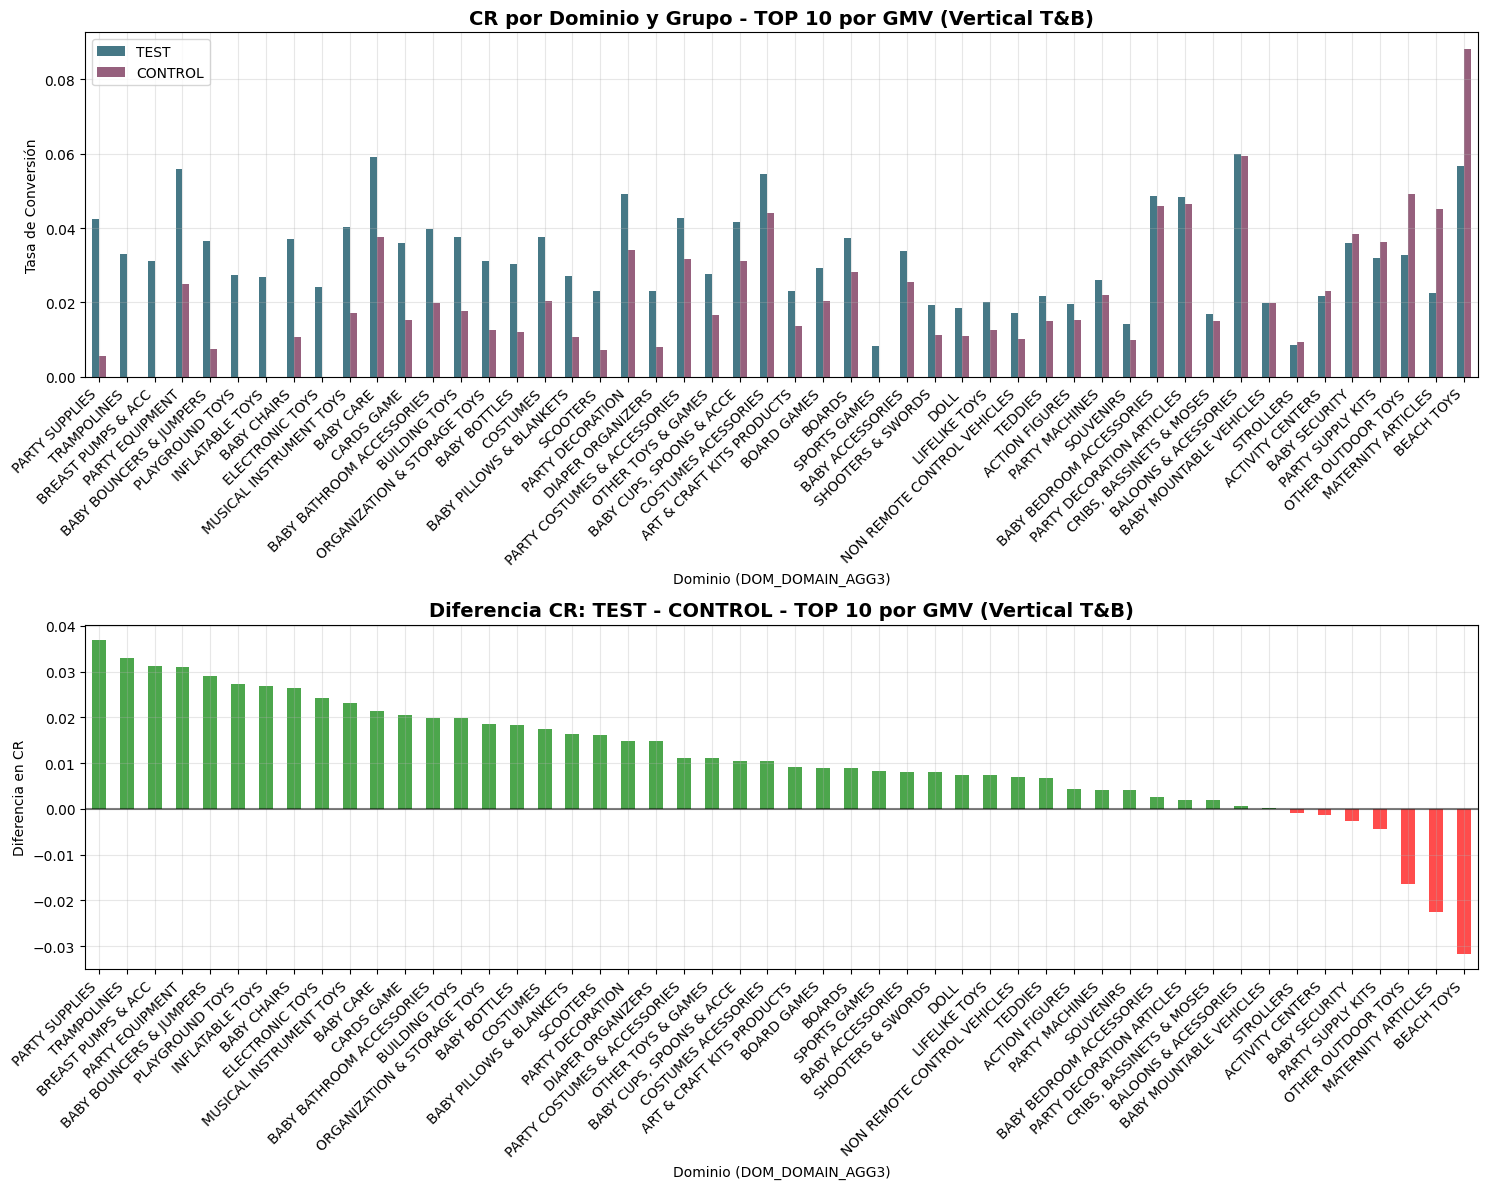


🧪 TESTS DE SIGNIFICANCIA ESTADÍSTICA - TOP 10 DOMINIOS:
--------------------------------------------------------------------------------
🌐 PARTY SUPPLIES:
   TEST: 80/1888 (0.042) | CONTROL: 1/180 (0.006)
   Diferencia: 0.037 (3.68pp) | IC95: [0.023, 0.051] | p=3.46e-07 ***
🌐 TRAMPOLINES:
   TEST: 27/817 (0.033) | CONTROL: 0/53 (0.000)
   Diferencia: 0.033 (3.30pp) | IC95: [0.021, 0.045] | p=1.26e-07 ***
🌐 BREAST PUMPS & ACC:
   TEST: 18/578 (0.031) | CONTROL: 0/66 (0.000)
   Diferencia: 0.031 (3.11pp) | IC95: [0.017, 0.045] | p=1.63e-05 ***
🌐 PARTY EQUIPMENT:
   TEST: 23/411 (0.056) | CONTROL: 1/40 (0.025)
   Diferencia: 0.031 (3.10pp) | IC95: [-0.022, 0.084] | p=0.254 
🌐 BABY BOUNCERS & JUMPERS:
   TEST: 62/1695 (0.037) | CONTROL: 1/132 (0.008)
   Diferencia: 0.029 (2.90pp) | IC95: [0.012, 0.046] | p=0.001 **
🌐 PLAYGROUND TOYS:
   TEST: 27/990 (0.027) | CONTROL: 0/93 (0.000)
   Diferencia: 0.027 (2.73pp) | IC95: [0.017, 0.037] | p=1.38e-07 ***
🌐 INFLATABLE TOYS:
   TEST: 9/335 (0.02

In [ ]:
# =======================
# TOP 10 DOM_DOMAIN_AGG3 CON MAYOR GMV_USD - VERTICAL T&B
# =======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

print("\n" + "="*80)
print(" TOP 10 DOM_DOMAIN_AGG3 CON MAYOR GMV_USD - VERTICAL T&B")
print("="*80)


print(" Verificando columnas disponibles...")
print("   Columnas en el DataFrame:", df.columns.tolist())
print("   Shape del DataFrame:", df.shape)


user_cols = [col for col in df.columns if 'CUS' in col.upper() or 'USER' in col.upper() or 'ID' in col.upper()]
print(f"   Columnas de usuario encontradas: {user_cols}")

if user_cols:
    USER_COL = user_cols[0]
    print(f"   Usando columna de usuario: {USER_COL}")
else:
    USER_COL = 'index'
    df = df.reset_index()
    print(f"   No se encontró columna de usuario, usando índice")


print(f"\n📊 Verticales disponibles:")
verticales = df['VERTICAL'].unique()
print(f"   {verticales}")


tb_variations = ['T&B', 'T & B', 'T&B', 'T AND B', 'TAND B']
df_tb = None

for variation in tb_variations:
    if variation in verticales:
        df_tb = df[df['VERTICAL'] == variation].copy()
        print(f"   ✅ Encontrada vertical: '{variation}'")
        break

if df_tb is None:
    print("   ❌ No se encontró la vertical T&B")
    print("   Verticales disponibles:", verticales)
    exit()

print(f"   Registros T&B: {len(df_tb):,}")
print(f"   Usuarios únicos T&B: {df_tb[USER_COL].nunique():,}")


required_cols = ['DOM_DOMAIN_AGG3', 'GMV_USD', 'GRUPO', 'QTY_ORDERS']
missing_cols = [col for col in required_cols if col not in df_tb.columns]
if missing_cols:
    print(f"❌ Columnas faltantes: {missing_cols}")
    print("   Columnas disponibles:", df_tb.columns.tolist())
    exit()


print("\n🔧 Preparando datos...")
df_tb_clean = df_tb.copy()


df_tb_clean['DOM_DOMAIN_AGG3'] = df_tb_clean['DOM_DOMAIN_AGG3'].fillna('SIN_DOMINIO')
df_tb_clean['DOM_DOMAIN_AGG3'] = df_tb_clean['DOM_DOMAIN_AGG3'].astype(str).str.strip()


df_tb_clean['GMV_USD'] = pd.to_numeric(df_tb_clean['GMV_USD'], errors='coerce').fillna(0)

print(f"   Dominios únicos: {df_tb_clean['DOM_DOMAIN_AGG3'].nunique()}")
print(f"   GMV_USD total: ${df_tb_clean['GMV_USD'].sum():,.2f}")


print("\n Calculando GMV por dominio...")
gmv_by_domain = (df_tb_clean.groupby('DOM_DOMAIN_AGG3')
                .agg(
                    total_gmv=('GMV_USD', 'sum'),
                    avg_gmv=('GMV_USD', 'mean'),
                    n_transactions=('GMV_USD', 'count'),
                    n_users=(USER_COL, 'nunique')
                )
                .reset_index()
                .sort_values('total_gmv', ascending=False))

print(f"   Dominios con GMV > 0: {len(gmv_by_domain[gmv_by_domain['total_gmv'] > 0])}")


print("\n🏆 TOP 10 DOMINIOS POR GMV_USD:")
print("-" * 80)

top_10_domains = gmv_by_domain.head(50)
print(f"   Dominios seleccionados: {len(top_10_domains)}")


display_gmv = top_10_domains.copy()
display_gmv['total_gmv_millions'] = (display_gmv['total_gmv'] / 1_000_000).round(2)
display_gmv['avg_gmv'] = display_gmv['avg_gmv'].round(2)
display_gmv['n_transactions'] = display_gmv['n_transactions'].astype(int)
display_gmv['n_users'] = display_gmv['n_users'].astype(int)

print(display_gmv[['DOM_DOMAIN_AGG3', 'total_gmv_millions', 'avg_gmv', 'n_transactions', 'n_users']].to_string(index=False))


print("\n🔍 Filtrando datos para top 10 dominios...")
top_10_domain_list = top_10_domains['DOM_DOMAIN_AGG3'].tolist()
df_tb_top10 = df_tb_clean[df_tb_clean['DOM_DOMAIN_AGG3'].isin(top_10_domain_list)].copy()

print(f"   Registros en top 10 dominios: {len(df_tb_top10):,}")
print(f"   Usuarios únicos en top 10: {df_tb_top10[USER_COL].nunique():,}")


print("\n📊 Calculando CR por usuario para top 10 dominios...")
df_tb_top10_users = (df_tb_top10.assign(conv=(df_tb_top10['QTY_ORDERS'].fillna(0) > 0))
                    .groupby([USER_COL, 'GRUPO', 'DOM_DOMAIN_AGG3'], as_index=False)['conv'].max())


print("\n Agregando métricas por GRUPO y DOM_DOMAIN_AGG3...")
cr_by_domain_top10 = (df_tb_top10_users.groupby(['GRUPO', 'DOM_DOMAIN_AGG3'])
                    .agg(
                        n_users=(USER_COL, 'nunique'),
                        n_conv=('conv', 'sum'),
                        cr=('conv', 'mean')
                    )
                    .reset_index())


print("\n📋 TABLA DE RESULTADOS - TOP 10 DOMINIOS:")
print("-" * 80)
display_df = cr_by_domain_top10.copy()
display_df['cr_pct'] = (display_df['cr'] * 100).round(2)
display_df['n_conv'] = display_df['n_conv'].astype(int)
display_df['n_users'] = display_df['n_users'].astype(int)


display_df = display_df.sort_values(['GRUPO', 'cr'], ascending=[True, False])
print(display_df[['GRUPO', 'DOM_DOMAIN_AGG3', 'n_users', 'n_conv', 'cr_pct']].to_string(index=False))


print("\n CREANDO PIVOT PARA ANÁLISIS...")
pivot_cr = cr_by_domain_top10.pivot(index='DOM_DOMAIN_AGG3', columns='GRUPO', values='cr')
pivot_users = cr_by_domain_top10.pivot(index='DOM_DOMAIN_AGG3', columns='GRUPO', values='n_users')


if 'TEST' in pivot_cr.columns and 'CONTROL' in pivot_cr.columns:
    pivot_cr['DIFERENCIA'] = pivot_cr['TEST'] - pivot_cr['CONTROL']
    pivot_cr['DIFERENCIA_PCT'] = ((pivot_cr['TEST'] - pivot_cr['CONTROL']) / pivot_cr['CONTROL'] * 100).round(2)
    
 
    pivot_cr = pivot_cr.sort_values('DIFERENCIA', ascending=False)
    
    print("\n🎯 DIFERENCIAS TEST vs CONTROL - TOP 10 DOMINIOS:")
    print("-" * 80)
    diff_display = pivot_cr[['TEST', 'CONTROL', 'DIFERENCIA', 'DIFERENCIA_PCT']].copy()
    diff_display['TEST'] = (diff_display['TEST'] * 100).round(2)
    diff_display['CONTROL'] = (diff_display['CONTROL'] * 100).round(2)
    diff_display['DIFERENCIA'] = (diff_display['DIFERENCIA'] * 100).round(2)
    print(diff_display.to_string())

#Gráficos
print("\n📈 CREANDO GRÁFICOS...")

# CR por dominio y grupo
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Gráfico de barras
if 'TEST' in pivot_cr.columns and 'CONTROL' in pivot_cr.columns:
    pivot_cr[['TEST', 'CONTROL']].plot(kind='bar', ax=ax1, color=['#467886ff', '#96607dff'])
    ax1.set_title('CR por Dominio y Grupo - TOP 10 por GMV (Vertical T&B)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Tasa de Conversión')
    ax1.set_xlabel('Dominio (DOM_DOMAIN_AGG3)')
    ax1.grid(True, alpha=0.3)
    ax1.legend(['TEST', 'CONTROL'])
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# Gráfico de diferencias
if 'DIFERENCIA' in pivot_cr.columns:
    # Filtrar valores NaN y crear colores
    diff_clean = pivot_cr['DIFERENCIA'].dropna()
    colors = ['green' if x > 0 else 'red' for x in diff_clean]
    
    # Crear gráfico solo con valores válidos
    diff_clean.plot(kind='bar', ax=ax2, color=colors, alpha=0.7)
    ax2.set_title('Diferencia CR: TEST - CONTROL - TOP 10 por GMV (Vertical T&B)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Diferencia en CR')
    ax2.set_xlabel('Dominio (DOM_DOMAIN_AGG3)')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Test de significancia estadística
print("\n🧪 TESTS DE SIGNIFICANCIA ESTADÍSTICA - TOP 10 DOMINIOS:")
print("-" * 80)

if 'TEST' in pivot_cr.columns and 'CONTROL' in pivot_cr.columns:
    for domain in pivot_cr.index:
        # Obtener datos para este dominio
        domain_data = cr_by_domain_top10[
            cr_by_domain_top10['DOM_DOMAIN_AGG3'] == domain
        ]
        
        if len(domain_data) == 2:  # Ambos grupos presentes
            test_data = domain_data[domain_data['GRUPO'] == 'TEST'].iloc[0]
            control_data = domain_data[domain_data['GRUPO'] == 'CONTROL'].iloc[0]
            
            n1, x1 = test_data['n_users'], test_data['n_conv']
            n0, x0 = control_data['n_users'], control_data['n_conv']
            
            p1, p0 = x1/n1, x0/n0
            se = np.sqrt(p1*(1-p1)/n1 + p0*(1-p0)/n0)
            diff = p1 - p0
            z = 0 if se == 0 else diff/se
            pval = 2*(1 - stats.norm.cdf(abs(z)))
            ci = (diff - 1.96*se, diff + 1.96*se)
            
            significance = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else ""
            
            print(f"🌐 {domain}:")
            print(f"   TEST: {x1}/{n1} ({p1:.3f}) | CONTROL: {x0}/{n0} ({p0:.3f})")
            print(f"   Diferencia: {diff:.3f} ({diff*100:.2f}pp) | IC95: [{ci[0]:.3f}, {ci[1]:.3f}] | p={pval:.3g} {significance}")

# Resumen 
print("\n" + "="*80)
print("📊 RESUMEN EJECUTIVO - TOP 10 DOMINIOS POR GMV")
print("="*80)

if 'DIFERENCIA' in pivot_cr.columns:
    # Filtrar valores NaN para estadísticas
    diff_clean = pivot_cr['DIFERENCIA'].dropna()
    
    if len(diff_clean) > 0:
        # Estadísticas generales
        total_domains = len(diff_clean)
        positive_diffs = len(diff_clean[diff_clean > 0])
        negative_diffs = len(diff_clean[diff_clean < 0])
        
        avg_diff = diff_clean.mean()
        max_diff = diff_clean.max()
        min_diff = diff_clean.min()
        
        print(f"🎯 DOMINIOS ANALIZADOS: {total_domains}")
        print(f"📈 DIFERENCIAS POSITIVAS: {positive_diffs} ({positive_diffs/total_domains*100:.1f}%)")
        print(f"📉 DIFERENCIAS NEGATIVAS: {negative_diffs} ({negative_diffs/total_domains*100:.1f}%)")
        print(f"📊 DIFERENCIA PROMEDIO: {avg_diff:.3f} ({avg_diff*100:.2f}pp)")
        print(f"🔝 MEJOR DIFERENCIA: {max_diff:.3f} ({max_diff*100:.2f}pp)")
        print(f" PEOR DIFERENCIA: {min_diff:.3f} ({min_diff*100:.2f}pp)")
        
        # Top 3 dominios con mejor performance
        top_3 = diff_clean.nlargest(3)
        print(f"\n TOP 3 DOMINIOS CON MEJOR PERFORMANCE:")
        for i, (domain, diff) in enumerate(top_3.items(), 1):
            print(f"   {i}. {domain}: +{diff:.3f} ({diff*100:.2f}pp)")
    else:
        print("❌ No hay diferencias válidas para calcular estadísticas")


print("\n💾 EXPORTANDO DATOS DE GRÁFICOS PARA HERRAMIENTAS EXTERNAS...")
timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")

# =========================
# GRÁFICO 1: CR POR DOMINIO Y GRUPO
# =========================
if 'TEST' in pivot_cr.columns and 'CONTROL' in pivot_cr.columns:
    
    chart1_data = pivot_cr[['TEST', 'CONTROL']].copy()
    chart1_data['TEST_PCT'] = (chart1_data['TEST'] * 100).round(2)
    chart1_data['CONTROL_PCT'] = (chart1_data['CONTROL'] * 100).round(2)
    chart1_data['DIFERENCIA_ABSOLUTA'] = (chart1_data['TEST'] - chart1_data['CONTROL']).round(4)
    chart1_data['DIFERENCIA_PORCENTUAL'] = ((chart1_data['TEST'] - chart1_data['CONTROL']) / chart1_data['CONTROL'] * 100).round(2)
    
    chart1_data['DOMINIO'] = chart1_data.index
    chart1_data = chart1_data.reset_index(drop=True)
    
    chart1_data = chart1_data[['DOMINIO', 'TEST', 'CONTROL', 'TEST_PCT', 'CONTROL_PCT', 
                              'DIFERENCIA_ABSOLUTA', 'DIFERENCIA_PORCENTUAL']]
    
    chart1_filename = f"grafico1_cr_por_dominio_grupo_{timestamp}.csv"
    chart1_data.to_csv(chart1_filename, index=False)
    print(f"✅ Gráfico 1 - CR por Dominio y Grupo: {chart1_filename}")
    print(f"   Filas: {len(chart1_data)}, Columnas: {len(chart1_data.columns)}")

# =========================
# GRÁFICO 2: DIFERENCIAS CR
# =========================
if 'DIFERENCIA' in pivot_cr.columns:

    chart2_data = pivot_cr[['DIFERENCIA', 'DIFERENCIA_PCT']].copy()
    chart2_data['DIFERENCIA_PCT_CLEAN'] = chart2_data['DIFERENCIA_PCT'].fillna(0)
    chart2_data['DIFERENCIA_ABSOLUTA'] = chart2_data['DIFERENCIA'].fillna(0)
    chart2_data['SIGNIFICANCIA'] = chart2_data['DIFERENCIA_ABSOLUTA'].apply(
        lambda x: 'POSITIVA' if x > 0 else 'NEGATIVA' if x < 0 else 'NEUTRA'
    )
    chart2_data['DOMINIO'] = chart2_data.index
    chart2_data = chart2_data.reset_index(drop=True)
    
 
    chart2_data = chart2_data[['DOMINIO', 'DIFERENCIA_ABSOLUTA', 'DIFERENCIA_PCT_CLEAN', 
                              'SIGNIFICANCIA', 'DIFERENCIA', 'DIFERENCIA_PCT']]
    
    chart2_filename = f"grafico2_diferencias_cr_{timestamp}.csv"
    chart2_data.to_csv(chart2_filename, index=False)
    print(f"✅ Gráfico 2 - Diferencias CR: {chart2_filename}")
    print(f"   Filas: {len(chart2_data)}, Columnas: {len(chart2_data.columns)}")

# =========================
# GRÁFICO 3: DATOS DETALLADOS POR DOMINIO
# =========================

chart3_data = []
for domain in pivot_cr.index:
    domain_data = cr_by_domain_top10[
        cr_by_domain_top10['DOM_DOMAIN_AGG3'] == domain
    ]
    
    if len(domain_data) == 2:  # Ambos grupos presentes
        test_data = domain_data[domain_data['GRUPO'] == 'TEST'].iloc[0]
        control_data = domain_data[domain_data['GRUPO'] == 'CONTROL'].iloc[0]
        
     
        gmv_data = gmv_by_domain[gmv_by_domain['DOM_DOMAIN_AGG3'] == domain].iloc[0]
        
        chart3_data.append({
            'DOMINIO': domain,
            'TEST_USERS': test_data['n_users'],
            'TEST_CONV': test_data['n_conv'],
            'TEST_CR': test_data['cr'],
            'TEST_CR_PCT': test_data['cr'] * 100,
            'CONTROL_USERS': control_data['n_users'],
            'CONTROL_CONV': control_data['n_conv'],
            'CONTROL_CR': control_data['cr'],
            'CONTROL_CR_PCT': control_data['cr'] * 100,
            'DIFERENCIA_ABSOLUTA': test_data['cr'] - control_data['cr'],
            'DIFERENCIA_PORCENTUAL': ((test_data['cr'] - control_data['cr']) / control_data['cr'] * 100) if control_data['cr'] > 0 else 0,
            'TOTAL_GMV_USD': gmv_data['total_gmv'],
            'TOTAL_GMV_MILLIONS': gmv_data['total_gmv'] / 1_000_000,
            'AVG_GMV_USD': gmv_data['avg_gmv'],
            'N_TRANSACTIONS': gmv_data['n_transactions'],
            'N_USERS_TOTAL': gmv_data['n_users']
        })

if chart3_data:
    chart3_df = pd.DataFrame(chart3_data)
    chart3_df = chart3_df.round(4)
    chart3_filename = f"grafico3_datos_detallados_dominios_{timestamp}.csv"
    chart3_df.to_csv(chart3_filename, index=False)
    print(f"✅ Gráfico 3 - Datos Detallados por Dominio: {chart3_filename}")
    print(f"   Filas: {len(chart3_df)}, Columnas: {len(chart3_df.columns)}")

# =========================
# GRÁFICO 4: DATOS PARA GRÁFICO DE BARRAS APILADAS
# =========================

chart4_data = []
for domain in pivot_cr.index:
    domain_data = cr_by_domain_top10[
        cr_by_domain_top10['DOM_DOMAIN_AGG3'] == domain
    ]
    
    if len(domain_data) == 2:
        test_data = domain_data[domain_data['GRUPO'] == 'TEST'].iloc[0]
        control_data = domain_data[domain_data['GRUPO'] == 'CONTROL'].iloc[0]
    
        chart4_data.append({
            'DOMINIO': domain,
            'GRUPO': 'TEST',
            'USERS': test_data['n_users'],
            'CONV': test_data['n_conv'],
            'CR': test_data['cr'],
            'CR_PCT': test_data['cr'] * 100
        })
        
        chart4_data.append({
            'DOMINIO': domain,
            'GRUPO': 'CONTROL',
            'USERS': control_data['n_users'],
            'CONV': control_data['n_conv'],
            'CR': control_data['cr'],
            'CR_PCT': control_data['cr'] * 100
        })

if chart4_data:
    chart4_df = pd.DataFrame(chart4_data)
    chart4_df = chart4_df.round(4)
    chart4_filename = f"grafico4_datos_barras_apiladas_{timestamp}.csv"
    chart4_df.to_csv(chart4_filename, index=False)
    print(f"✅ Gráfico 4 - Datos para Barras Apiladas: {chart4_filename}")
    print(f"   Filas: {len(chart4_df)}, Columnas: {len(chart4_df.columns)}")

# =========================
# GRÁFICO 5: DATOS PARA GRÁFICO DE LÍNEAS (SERIE TEMPORAL)
# =========================

chart5_data = []
for domain in pivot_cr.index:
    domain_data = cr_by_domain_top10[
        cr_by_domain_top10['DOM_DOMAIN_AGG3'] == domain
    ]
    
    if len(domain_data) == 2:
        test_data = domain_data[domain_data['GRUPO'] == 'TEST'].iloc[0]
        control_data = domain_data[domain_data['GRUPO'] == 'CONTROL'].iloc[0]
        
        chart5_data.append({
            'DOMINIO': domain,
            'TEST_CR': test_data['cr'],
            'CONTROL_CR': control_data['cr'],
            'DIFERENCIA': test_data['cr'] - control_data['cr'],
            'DIFERENCIA_PCT': ((test_data['cr'] - control_data['cr']) / control_data['cr'] * 100) if control_data['cr'] > 0 else 0
        })

if chart5_data:
    chart5_df = pd.DataFrame(chart5_data)
    chart5_df = chart5_df.round(4)
    chart5_filename = f"grafico5_datos_lineas_{timestamp}.csv"
    chart5_df.to_csv(chart5_filename, index=False)
    print(f"✅ Gráfico 5 - Datos para Gráfico de Líneas: {chart5_filename}")
    print(f"   Filas: {len(chart5_df)}, Columnas: {len(chart5_df.columns)}")

# =========================
# RESUMEN DE ARCHIVOS EXPORTADOS
# =========================
print(f"\n📋 RESUMEN DE ARCHIVOS EXPORTADOS:")
print("-" * 80)
print(f"🎯 ARCHIVOS PARA GRÁFICOS:")
print(f"   1. {chart1_filename} - CR por Dominio y Grupo")
print(f"   2. {chart2_filename} - Diferencias CR")
print(f"   3. {chart3_filename} - Datos Detallados por Dominio")
print(f"   4. {chart4_filename} - Datos para Barras Apiladas")
print(f"   5. {chart5_filename} - Datos para Gráfico de Líneas")

print(f"\n💡 INSTRUCCIONES PARA USAR EN OTRAS HERRAMIENTAS:")
print(f"   • Excel/PowerBI: Importa los archivos CSV directamente")
print(f"   • Tableau: Usa 'Text File' como fuente de datos")
print(f"   • Python: pd.read_csv('{chart1_filename}')")
print(f"   • R: read.csv('{chart1_filename}')")
print(f"   • SQL: Importa como tabla temporal")


print("\n💾 EXPORTANDO RESULTADOS ADICIONALES...")


cr_by_domain_top10.to_csv(f"cr_tb_top10_gmv_{timestamp}.csv", index=False)
print(f"✅ Tabla completa guardada: cr_tb_top10_gmv_{timestamp}.csv")


if 'TEST' in pivot_cr.columns and 'CONTROL' in pivot_cr.columns:
    pivot_cr.to_csv(f"cr_tb_pivot_top10_gmv_{timestamp}.csv")
    print(f"✅ Pivot guardado: cr_tb_pivot_top10_gmv_{timestamp}.csv")


if 'DIFERENCIA' in pivot_cr.columns:
    summary_data = []
    for domain in pivot_cr.index:
        domain_data = cr_by_domain_top10[
            cr_by_domain_top10['DOM_DOMAIN_AGG3'] == domain
        ]
        
        if len(domain_data) == 2:
            test_data = domain_data[domain_data['GRUPO'] == 'TEST'].iloc[0]
            control_data = domain_data[domain_data['GRUPO'] == 'CONTROL'].iloc[0]
            
         
            if not pd.isna(pivot_cr.loc[domain, 'DIFERENCIA']):
                summary_data.append({
                    'DOMINIO': domain,
                    'TEST_USERS': test_data['n_users'],
                    'TEST_CR': test_data['cr'],
                    'CONTROL_USERS': control_data['n_users'],
                    'CONTROL_CR': control_data['cr'],
                    'DIFERENCIA_ABSOLUTA': pivot_cr.loc[domain, 'DIFERENCIA'],
                    'DIFERENCIA_PORCENTUAL': pivot_cr.loc[domain, 'DIFERENCIA_PCT']
                })
    
    if summary_data:
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_csv(f"resumen_tb_top10_gmv_{timestamp}.csv", index=False)
        print(f"✅ Resumen guardado: resumen_tb_top10_gmv_{timestamp}.csv")
    else:
        print("⚠️ No hay datos válidos para el resumen")

print(f"\n✅ Análisis completado exitosamente!")
print("="*80)


 TOP 10 DOM_DOMAIN_AGG3 CON MAYOR GMV_USD - VERTICAL VEHICLE PARTS & ACCESSORIES
 Verificando columnas disponibles...
   Columnas en el DataFrame: ['PHOTO_DATE', 'CUS_CUST_ID', 'ITE_ITEM_ID', 'SI', 'GRUPO', 'GMV_USD', 'GMV_USD_CON_VC_UE', 'QTY_ORDERS', 'ACTUAL_PRICE', 'ORIGINAL_PRICE', 'PROMOTION_DISCOUNT_PCT', 'COUPON_STATUS', 'COUPON_PCT_DISCOUNT', 'VERTICAL', 'PLATFORM', 'INSTALLMENTS', 'POWER_SELLER_STATUS', 'REPUTATION_LEVEL', 'DOM_DOMAIN_AGG2', 'DOM_DOMAIN_AGG3', 'IS_FREE_INSTALLMENTS', 'FREE_SHIPPING', 'HIGHLIGHT_ID', 'genero', 'rango_edad', 'rn']
   Shape del DataFrame: (3262672, 26)
   Columnas de usuario encontradas: ['CUS_CUST_ID', 'ITE_ITEM_ID', 'HIGHLIGHT_ID']
   Usando columna de usuario: CUS_CUST_ID

📊 Verticales disponibles:
   ['FASHION' 'TECHNOLOGY' 'CONSTRUCTION & INDUSTRY' 'SPORTS' 'CPG' 'T & B'
 'HOME ELECTRONICS' 'FURNISHING & HOUSEWARE' 'BEAUTY'
 'VEHICLE PARTS & ACCESSORIES' 'HEALTH' 'ENTERTAINMENT' 'OTHERS']
   ✅ Encontrada vertical: 'VEHICLE PARTS & ACCESSORI

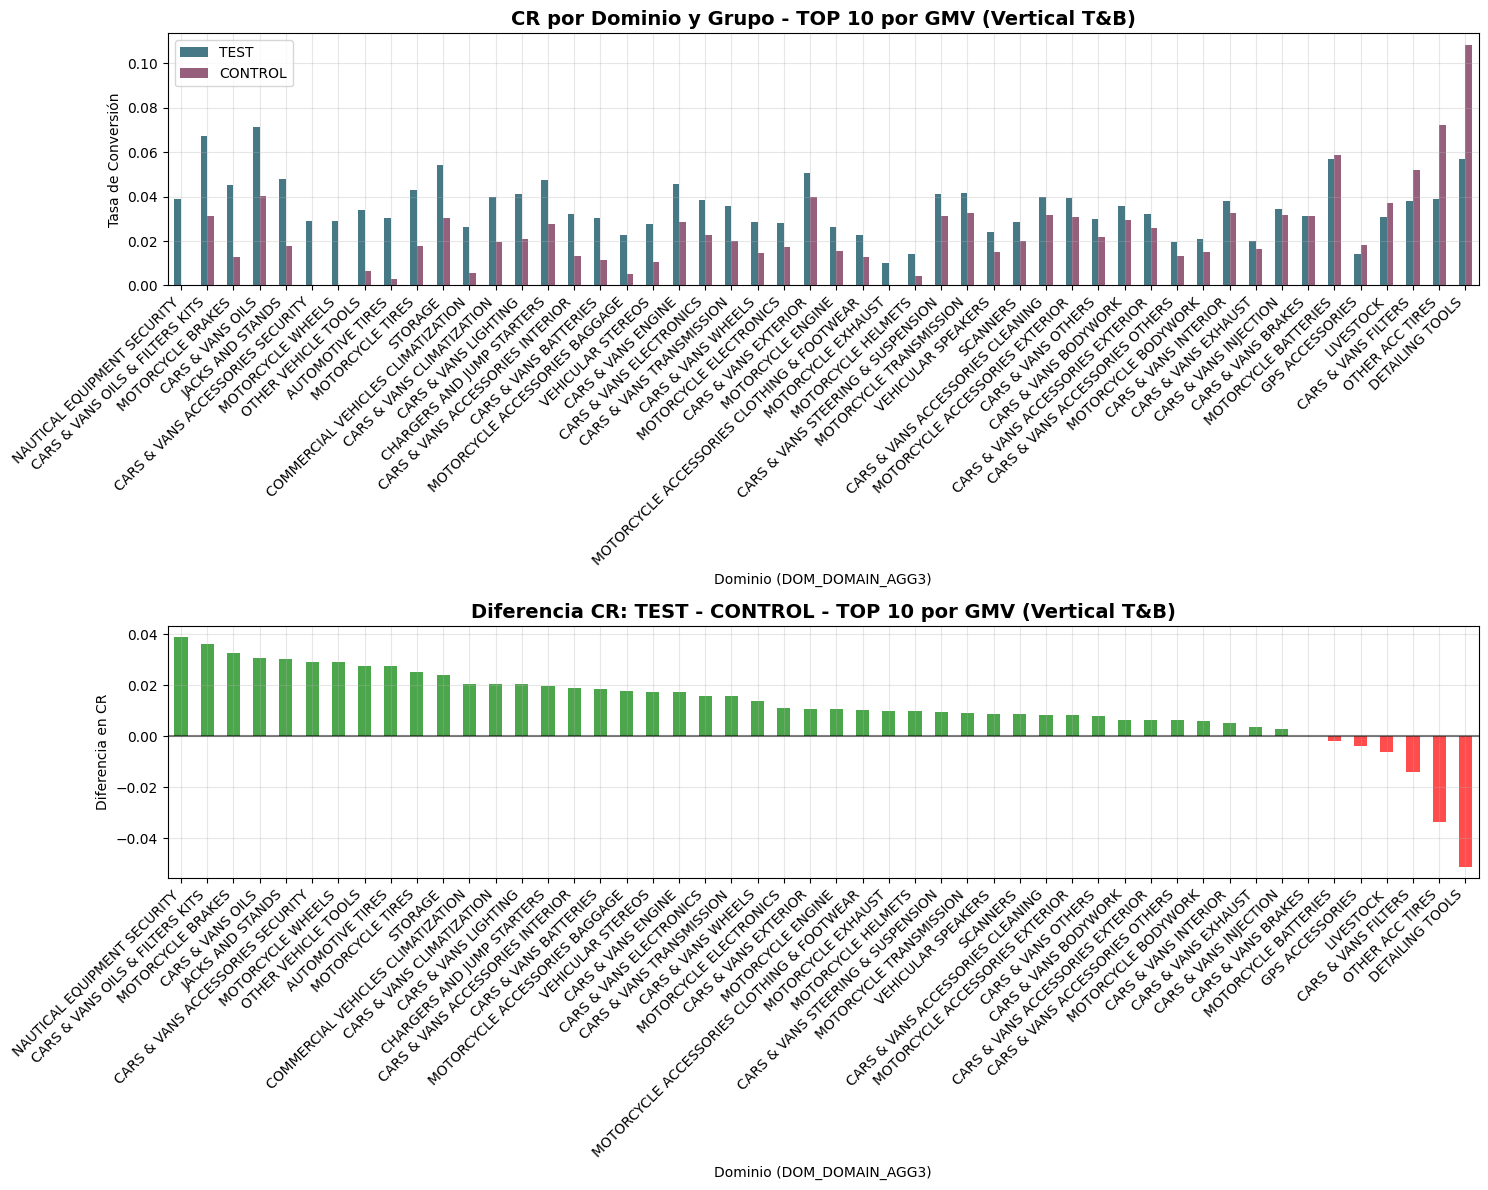


🧪 TESTS DE SIGNIFICANCIA ESTADÍSTICA - TOP 10 DOMINIOS:
--------------------------------------------------------------------------------
🌐 NAUTICAL EQUIPMENT SECURITY:
   TEST: 17/438 (0.039) | CONTROL: 0/38 (0.000)
   Diferencia: 0.039 (3.88pp) | IC95: [0.021, 0.057] | p=2.6e-05 ***
🌐 CARS & VANS OILS & FILTERS KITS:
   TEST: 174/2581 (0.067) | CONTROL: 7/224 (0.031)
   Diferencia: 0.036 (3.62pp) | IC95: [0.011, 0.061] | p=0.00419 **
🌐 MOTORCYCLE BRAKES:
   TEST: 39/858 (0.045) | CONTROL: 1/78 (0.013)
   Diferencia: 0.033 (3.26pp) | IC95: [0.004, 0.061] | p=0.0253 *
🌐 CARS & VANS OILS:
   TEST: 198/2777 (0.071) | CONTROL: 10/247 (0.040)
   Diferencia: 0.031 (3.08pp) | IC95: [0.004, 0.057] | p=0.022 *
🌐 JACKS AND STANDS:
   TEST: 149/3100 (0.048) | CONTROL: 5/281 (0.018)
   Diferencia: 0.030 (3.03pp) | IC95: [0.013, 0.047] | p=0.000559 ***
🌐 CARS & VANS ACCESSORIES SECURITY:
   TEST: 32/1095 (0.029) | CONTROL: 0/106 (0.000)
   Diferencia: 0.029 (2.92pp) | IC95: [0.019, 0.039] | p=9.39

In [ ]:
# =======================
# TOP 10 DOM_DOMAIN_AGG3 CON MAYOR GMV_USD - VERTICAL VEHICLE PARTS & ACCESSORIES
# =======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

print("\n" + "="*80)
print(" TOP 10 DOM_DOMAIN_AGG3 CON MAYOR GMV_USD - VERTICAL VEHICLE PARTS & ACCESSORIES")
print("="*80)


print(" Verificando columnas disponibles...")
print("   Columnas en el DataFrame:", df.columns.tolist())
print("   Shape del DataFrame:", df.shape)


user_cols = [col for col in df.columns if 'CUS' in col.upper() or 'USER' in col.upper() or 'ID' in col.upper()]
print(f"   Columnas de usuario encontradas: {user_cols}")

if user_cols:
    USER_COL = user_cols[0]
    print(f"   Usando columna de usuario: {USER_COL}")
else:
    USER_COL = 'index'
    df = df.reset_index()
    print(f"   No se encontró columna de usuario, usando índice")


print(f"\n📊 Verticales disponibles:")
verticales = df['VERTICAL'].unique()
print(f"   {verticales}")


tb_variations = ['VEHICLE PARTS & ACCESSORIES', 'VEHICLE PARTS AND ACCESSORIES']
df_tb = None

for variation in tb_variations:
    if variation in verticales:
        df_tb = df[df['VERTICAL'] == variation].copy()
        print(f"   ✅ Encontrada vertical: '{variation}'")
        break

if df_tb is None:
    print("   ❌ No se encontró la vertical VEHICLE PARTS & ACCESSORIES")
    print("   Verticales disponibles:", verticales)
    exit()

print(f"   Registros VEHICLE PARTS & ACCESSORIES: {len(df_tb):,}")
print(f"   Usuarios únicos VEHICLE PARTS & ACCESSORIES: {df_tb[USER_COL].nunique():,}")


required_cols = ['DOM_DOMAIN_AGG3', 'GMV_USD', 'GRUPO', 'QTY_ORDERS']
missing_cols = [col for col in required_cols if col not in df_tb.columns]
if missing_cols:
    print(f"❌ Columnas faltantes: {missing_cols}")
    print("   Columnas disponibles:", df_tb.columns.tolist())
    exit()


print("\n🔧 Preparando datos...")
df_tb_clean = df_tb.copy()


df_tb_clean['DOM_DOMAIN_AGG3'] = df_tb_clean['DOM_DOMAIN_AGG3'].fillna('SIN_DOMINIO')
df_tb_clean['DOM_DOMAIN_AGG3'] = df_tb_clean['DOM_DOMAIN_AGG3'].astype(str).str.strip()


df_tb_clean['GMV_USD'] = pd.to_numeric(df_tb_clean['GMV_USD'], errors='coerce').fillna(0)

print(f"   Dominios únicos: {df_tb_clean['DOM_DOMAIN_AGG3'].nunique()}")
print(f"   GMV_USD total: ${df_tb_clean['GMV_USD'].sum():,.2f}")


print("\n Calculando GMV por dominio...")
gmv_by_domain = (df_tb_clean.groupby('DOM_DOMAIN_AGG3')
                .agg(
                    total_gmv=('GMV_USD', 'sum'),
                    avg_gmv=('GMV_USD', 'mean'),
                    n_transactions=('GMV_USD', 'count'),
                    n_users=(USER_COL, 'nunique')
                )
                .reset_index()
                .sort_values('total_gmv', ascending=False))

print(f"   Dominios con GMV > 0: {len(gmv_by_domain[gmv_by_domain['total_gmv'] > 0])}")


print("\n🏆 TOP 10 DOMINIOS POR GMV_USD:")
print("-" * 80)

top_10_domains = gmv_by_domain.head(50)
print(f"   Dominios seleccionados: {len(top_10_domains)}")


display_gmv = top_10_domains.copy()
display_gmv['total_gmv_millions'] = (display_gmv['total_gmv'] / 1_000_000).round(2)
display_gmv['avg_gmv'] = display_gmv['avg_gmv'].round(2)
display_gmv['n_transactions'] = display_gmv['n_transactions'].astype(int)
display_gmv['n_users'] = display_gmv['n_users'].astype(int)

print(display_gmv[['DOM_DOMAIN_AGG3', 'total_gmv_millions', 'avg_gmv', 'n_transactions', 'n_users']].to_string(index=False))


print("\n🔍 Filtrando datos para top 10 dominios...")
top_10_domain_list = top_10_domains['DOM_DOMAIN_AGG3'].tolist()
df_tb_top10 = df_tb_clean[df_tb_clean['DOM_DOMAIN_AGG3'].isin(top_10_domain_list)].copy()

print(f"   Registros en top 10 dominios: {len(df_tb_top10):,}")
print(f"   Usuarios únicos en top 10: {df_tb_top10[USER_COL].nunique():,}")


print("\n📊 Calculando CR por usuario para top 10 dominios...")
df_tb_top10_users = (df_tb_top10.assign(conv=(df_tb_top10['QTY_ORDERS'].fillna(0) > 0))
                    .groupby([USER_COL, 'GRUPO', 'DOM_DOMAIN_AGG3'], as_index=False)['conv'].max())


print("\n Agregando métricas por GRUPO y DOM_DOMAIN_AGG3...")
cr_by_domain_top10 = (df_tb_top10_users.groupby(['GRUPO', 'DOM_DOMAIN_AGG3'])
                    .agg(
                        n_users=(USER_COL, 'nunique'),
                        n_conv=('conv', 'sum'),
                        cr=('conv', 'mean')
                    )
                    .reset_index())


print("\n📋 TABLA DE RESULTADOS - TOP 10 DOMINIOS:")
print("-" * 80)
display_df = cr_by_domain_top10.copy()
display_df['cr_pct'] = (display_df['cr'] * 100).round(2)
display_df['n_conv'] = display_df['n_conv'].astype(int)
display_df['n_users'] = display_df['n_users'].astype(int)


display_df = display_df.sort_values(['GRUPO', 'cr'], ascending=[True, False])
print(display_df[['GRUPO', 'DOM_DOMAIN_AGG3', 'n_users', 'n_conv', 'cr_pct']].to_string(index=False))


print("\n CREANDO PIVOT PARA ANÁLISIS...")
pivot_cr = cr_by_domain_top10.pivot(index='DOM_DOMAIN_AGG3', columns='GRUPO', values='cr')
pivot_users = cr_by_domain_top10.pivot(index='DOM_DOMAIN_AGG3', columns='GRUPO', values='n_users')


if 'TEST' in pivot_cr.columns and 'CONTROL' in pivot_cr.columns:
    pivot_cr['DIFERENCIA'] = pivot_cr['TEST'] - pivot_cr['CONTROL']
    pivot_cr['DIFERENCIA_PCT'] = ((pivot_cr['TEST'] - pivot_cr['CONTROL']) / pivot_cr['CONTROL'] * 100).round(2)
    
    # Ordenar por diferencia
    pivot_cr = pivot_cr.sort_values('DIFERENCIA', ascending=False)
    
    print("\n🎯 DIFERENCIAS TEST vs CONTROL - TOP 10 DOMINIOS:")
    print("-" * 80)
    diff_display = pivot_cr[['TEST', 'CONTROL', 'DIFERENCIA', 'DIFERENCIA_PCT']].copy()
    diff_display['TEST'] = (diff_display['TEST'] * 100).round(2)
    diff_display['CONTROL'] = (diff_display['CONTROL'] * 100).round(2)
    diff_display['DIFERENCIA'] = (diff_display['DIFERENCIA'] * 100).round(2)
    print(diff_display.to_string())


print("\n📈 CREANDO GRÁFICOS...")

# Gráfico: CR por dominio y grupo
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Gráfico de barras
if 'TEST' in pivot_cr.columns and 'CONTROL' in pivot_cr.columns:
    pivot_cr[['TEST', 'CONTROL']].plot(kind='bar', ax=ax1, color=['#467886ff', '#96607dff'])
    ax1.set_title('CR por Dominio y Grupo - TOP 10 por GMV (Vertical T&B)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Tasa de Conversión')
    ax1.set_xlabel('Dominio (DOM_DOMAIN_AGG3)')
    ax1.grid(True, alpha=0.3)
    ax1.legend(['TEST', 'CONTROL'])
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# Gráfico de diferencias
if 'DIFERENCIA' in pivot_cr.columns:
    
    diff_clean = pivot_cr['DIFERENCIA'].dropna()
    colors = ['green' if x > 0 else 'red' for x in diff_clean]
    

    diff_clean.plot(kind='bar', ax=ax2, color=colors, alpha=0.7)
    ax2.set_title('Diferencia CR: TEST - CONTROL - TOP 10 por GMV (Vertical T&B)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Diferencia en CR')
    ax2.set_xlabel('Dominio (DOM_DOMAIN_AGG3)')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


print("\n🧪 TESTS DE SIGNIFICANCIA ESTADÍSTICA - TOP 10 DOMINIOS:")
print("-" * 80)

if 'TEST' in pivot_cr.columns and 'CONTROL' in pivot_cr.columns:
    for domain in pivot_cr.index:
       
        domain_data = cr_by_domain_top10[
            cr_by_domain_top10['DOM_DOMAIN_AGG3'] == domain
        ]
        
        if len(domain_data) == 2:  # Ambos grupos presentes
            test_data = domain_data[domain_data['GRUPO'] == 'TEST'].iloc[0]
            control_data = domain_data[domain_data['GRUPO'] == 'CONTROL'].iloc[0]
            
            n1, x1 = test_data['n_users'], test_data['n_conv']
            n0, x0 = control_data['n_users'], control_data['n_conv']
            
            p1, p0 = x1/n1, x0/n0
            se = np.sqrt(p1*(1-p1)/n1 + p0*(1-p0)/n0)
            diff = p1 - p0
            z = 0 if se == 0 else diff/se
            pval = 2*(1 - stats.norm.cdf(abs(z)))
            ci = (diff - 1.96*se, diff + 1.96*se)
            
            significance = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else ""
            
            print(f"🌐 {domain}:")
            print(f"   TEST: {x1}/{n1} ({p1:.3f}) | CONTROL: {x0}/{n0} ({p0:.3f})")
            print(f"   Diferencia: {diff:.3f} ({diff*100:.2f}pp) | IC95: [{ci[0]:.3f}, {ci[1]:.3f}] | p={pval:.3g} {significance}")


print("\n" + "="*80)
print("📊 RESUMEN EJECUTIVO - TOP 10 DOMINIOS POR GMV")
print("="*80)

if 'DIFERENCIA' in pivot_cr.columns:
   
    diff_clean = pivot_cr['DIFERENCIA'].dropna()
    
    if len(diff_clean) > 0:
      
        total_domains = len(diff_clean)
        positive_diffs = len(diff_clean[diff_clean > 0])
        negative_diffs = len(diff_clean[diff_clean < 0])
        
        avg_diff = diff_clean.mean()
        max_diff = diff_clean.max()
        min_diff = diff_clean.min()
        
        print(f"🎯 DOMINIOS ANALIZADOS: {total_domains}")
        print(f"📈 DIFERENCIAS POSITIVAS: {positive_diffs} ({positive_diffs/total_domains*100:.1f}%)")
        print(f"📉 DIFERENCIAS NEGATIVAS: {negative_diffs} ({negative_diffs/total_domains*100:.1f}%)")
        print(f"📊 DIFERENCIA PROMEDIO: {avg_diff:.3f} ({avg_diff*100:.2f}pp)")
        print(f"🔝 MEJOR DIFERENCIA: {max_diff:.3f} ({max_diff*100:.2f}pp)")
        print(f" PEOR DIFERENCIA: {min_diff:.3f} ({min_diff*100:.2f}pp)")
        
      
        top_3 = diff_clean.nlargest(3)
        print(f"\n TOP 3 DOMINIOS CON MEJOR PERFORMANCE:")
        for i, (domain, diff) in enumerate(top_3.items(), 1):
            print(f"   {i}. {domain}: +{diff:.3f} ({diff*100:.2f}pp)")
    else:
        print("❌ No hay diferencias válidas para calcular estadísticas")


print("\n💾 EXPORTANDO DATOS DE GRÁFICOS PARA HERRAMIENTAS EXTERNAS...")
timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")

# =========================
# GRÁFICO 1: CR POR DOMINIO Y GRUPO
# =========================
if 'TEST' in pivot_cr.columns and 'CONTROL' in pivot_cr.columns:
 
    chart1_data = pivot_cr[['TEST', 'CONTROL']].copy()
    chart1_data['TEST_PCT'] = (chart1_data['TEST'] * 100).round(2)
    chart1_data['CONTROL_PCT'] = (chart1_data['CONTROL'] * 100).round(2)
    chart1_data['DIFERENCIA_ABSOLUTA'] = (chart1_data['TEST'] - chart1_data['CONTROL']).round(4)
    chart1_data['DIFERENCIA_PORCENTUAL'] = ((chart1_data['TEST'] - chart1_data['CONTROL']) / chart1_data['CONTROL'] * 100).round(2)
    
    
    chart1_data['DOMINIO'] = chart1_data.index
    chart1_data = chart1_data.reset_index(drop=True)
    
    chart1_data = chart1_data[['DOMINIO', 'TEST', 'CONTROL', 'TEST_PCT', 'CONTROL_PCT', 
                              'DIFERENCIA_ABSOLUTA', 'DIFERENCIA_PORCENTUAL']]
    
 
    chart1_filename = f"grafico1_cr_por_dominio_grupo_{timestamp}.csv"
    chart1_data.to_csv(chart1_filename, index=False)
    print(f"✅ Gráfico 1 - CR por Dominio y Grupo: {chart1_filename}")
    print(f"   Filas: {len(chart1_data)}, Columnas: {len(chart1_data.columns)}")

# =========================
# GRÁFICO 2: DIFERENCIAS CR
# =========================
if 'DIFERENCIA' in pivot_cr.columns:
  
    chart2_data = pivot_cr[['DIFERENCIA', 'DIFERENCIA_PCT']].copy()
    chart2_data['DIFERENCIA_PCT_CLEAN'] = chart2_data['DIFERENCIA_PCT'].fillna(0)
    chart2_data['DIFERENCIA_ABSOLUTA'] = chart2_data['DIFERENCIA'].fillna(0)
    chart2_data['SIGNIFICANCIA'] = chart2_data['DIFERENCIA_ABSOLUTA'].apply(
        lambda x: 'POSITIVA' if x > 0 else 'NEGATIVA' if x < 0 else 'NEUTRA'
    )
    chart2_data['DOMINIO'] = chart2_data.index
    chart2_data = chart2_data.reset_index(drop=True)
    

    chart2_data = chart2_data[['DOMINIO', 'DIFERENCIA_ABSOLUTA', 'DIFERENCIA_PCT_CLEAN', 
                              'SIGNIFICANCIA', 'DIFERENCIA', 'DIFERENCIA_PCT']]
    
  
    chart2_filename = f"grafico2_diferencias_cr_{timestamp}.csv"
    chart2_data.to_csv(chart2_filename, index=False)
    print(f"✅ Gráfico 2 - Diferencias CR: {chart2_filename}")
    print(f"   Filas: {len(chart2_data)}, Columnas: {len(chart2_data.columns)}")

# =========================
# GRÁFICO 3: DATOS DETALLADOS
# =========================

chart3_data = []
for domain in pivot_cr.index:
    domain_data = cr_by_domain_top10[
        cr_by_domain_top10['DOM_DOMAIN_AGG3'] == domain
    ]
    
    if len(domain_data) == 2:  # Ambos grupos presentes
        test_data = domain_data[domain_data['GRUPO'] == 'TEST'].iloc[0]
        control_data = domain_data[domain_data['GRUPO'] == 'CONTROL'].iloc[0]
        
 
        gmv_data = gmv_by_domain[gmv_by_domain['DOM_DOMAIN_AGG3'] == domain].iloc[0]
        
        chart3_data.append({
            'DOMINIO': domain,
            'TEST_USERS': test_data['n_users'],
            'TEST_CONV': test_data['n_conv'],
            'TEST_CR': test_data['cr'],
            'TEST_CR_PCT': test_data['cr'] * 100,
            'CONTROL_USERS': control_data['n_users'],
            'CONTROL_CONV': control_data['n_conv'],
            'CONTROL_CR': control_data['cr'],
            'CONTROL_CR_PCT': control_data['cr'] * 100,
            'DIFERENCIA_ABSOLUTA': test_data['cr'] - control_data['cr'],
            'DIFERENCIA_PORCENTUAL': ((test_data['cr'] - control_data['cr']) / control_data['cr'] * 100) if control_data['cr'] > 0 else 0,
            'TOTAL_GMV_USD': gmv_data['total_gmv'],
            'TOTAL_GMV_MILLIONS': gmv_data['total_gmv'] / 1_000_000,
            'AVG_GMV_USD': gmv_data['avg_gmv'],
            'N_TRANSACTIONS': gmv_data['n_transactions'],
            'N_USERS_TOTAL': gmv_data['n_users']
        })

if chart3_data:
    chart3_df = pd.DataFrame(chart3_data)
    chart3_df = chart3_df.round(4)
    chart3_filename = f"grafico3_datos_detallados_dominios_{timestamp}.csv"
    chart3_df.to_csv(chart3_filename, index=False)
    print(f"✅ Gráfico 3 - Datos Detallados por Dominio: {chart3_filename}")
    print(f"   Filas: {len(chart3_df)}, Columnas: {len(chart3_df.columns)}")

# =========================
# GRÁFICO 4: DATOS PARA GRÁFICO DE BARRAS APILADAS
# =========================

chart4_data = []
for domain in pivot_cr.index:
    domain_data = cr_by_domain_top10[
        cr_by_domain_top10['DOM_DOMAIN_AGG3'] == domain
    ]
    
    if len(domain_data) == 2:
        test_data = domain_data[domain_data['GRUPO'] == 'TEST'].iloc[0]
        control_data = domain_data[domain_data['GRUPO'] == 'CONTROL'].iloc[0]
        
      
        chart4_data.append({
            'DOMINIO': domain,
            'GRUPO': 'TEST',
            'USERS': test_data['n_users'],
            'CONV': test_data['n_conv'],
            'CR': test_data['cr'],
            'CR_PCT': test_data['cr'] * 100
        })
        
     
        chart4_data.append({
            'DOMINIO': domain,
            'GRUPO': 'CONTROL',
            'USERS': control_data['n_users'],
            'CONV': control_data['n_conv'],
            'CR': control_data['cr'],
            'CR_PCT': control_data['cr'] * 100
        })

if chart4_data:
    chart4_df = pd.DataFrame(chart4_data)
    chart4_df = chart4_df.round(4)
    chart4_filename = f"grafico4_datos_barras_apiladas_{timestamp}.csv"
    chart4_df.to_csv(chart4_filename, index=False)
    print(f"✅ Gráfico 4 - Datos para Barras Apiladas: {chart4_filename}")
    print(f"   Filas: {len(chart4_df)}, Columnas: {len(chart4_df.columns)}")

# =========================
# GRÁFICO 5: DATOS PARA GRÁFICO DE LÍNEAS (SERIE TEMPORAL)
# =========================

chart5_data = []
for domain in pivot_cr.index:
    domain_data = cr_by_domain_top10[
        cr_by_domain_top10['DOM_DOMAIN_AGG3'] == domain
    ]
    
    if len(domain_data) == 2:
        test_data = domain_data[domain_data['GRUPO'] == 'TEST'].iloc[0]
        control_data = domain_data[domain_data['GRUPO'] == 'CONTROL'].iloc[0]
        
        chart5_data.append({
            'DOMINIO': domain,
            'TEST_CR': test_data['cr'],
            'CONTROL_CR': control_data['cr'],
            'DIFERENCIA': test_data['cr'] - control_data['cr'],
            'DIFERENCIA_PCT': ((test_data['cr'] - control_data['cr']) / control_data['cr'] * 100) if control_data['cr'] > 0 else 0
        })

if chart5_data:
    chart5_df = pd.DataFrame(chart5_data)
    chart5_df = chart5_df.round(4)
    chart5_filename = f"grafico5_datos_lineas_{timestamp}.csv"
    chart5_df.to_csv(chart5_filename, index=False)
    print(f"✅ Gráfico 5 - Datos para Gráfico de Líneas: {chart5_filename}")
    print(f"   Filas: {len(chart5_df)}, Columnas: {len(chart5_df.columns)}")

# =========================
# RESUMEN DE ARCHIVOS EXPORTADOS
# =========================
print(f"\n📋 RESUMEN DE ARCHIVOS EXPORTADOS:")
print("-" * 80)
print(f"🎯 ARCHIVOS PARA GRÁFICOS:")
print(f"   1. {chart1_filename} - CR por Dominio y Grupo")
print(f"   2. {chart2_filename} - Diferencias CR")
print(f"   3. {chart3_filename} - Datos Detallados por Dominio")
print(f"   4. {chart4_filename} - Datos para Barras Apiladas")
print(f"   5. {chart5_filename} - Datos para Gráfico de Líneas")

print(f"\n💡 INSTRUCCIONES PARA USAR EN OTRAS HERRAMIENTAS:")
print(f"   • Excel/PowerBI: Importa los archivos CSV directamente")
print(f"   • Tableau: Usa 'Text File' como fuente de datos")
print(f"   • Python: pd.read_csv('{chart1_filename}')")
print(f"   • R: read.csv('{chart1_filename}')")
print(f"   • SQL: Importa como tabla temporal")


print("\n💾 EXPORTANDO RESULTADOS ADICIONALES...")


cr_by_domain_top10.to_csv(f"cr_tb_top10_gmv_{timestamp}.csv", index=False)
print(f"✅ Tabla completa guardada: cr_tb_top10_gmv_{timestamp}.csv")


if 'TEST' in pivot_cr.columns and 'CONTROL' in pivot_cr.columns:
    pivot_cr.to_csv(f"cr_tb_pivot_top10_gmv_{timestamp}.csv")
    print(f"✅ Pivot guardado: cr_tb_pivot_top10_gmv_{timestamp}.csv")


if 'DIFERENCIA' in pivot_cr.columns:
    summary_data = []
    for domain in pivot_cr.index:
        domain_data = cr_by_domain_top10[
            cr_by_domain_top10['DOM_DOMAIN_AGG3'] == domain
        ]
        
        if len(domain_data) == 2:
            test_data = domain_data[domain_data['GRUPO'] == 'TEST'].iloc[0]
            control_data = domain_data[domain_data['GRUPO'] == 'CONTROL'].iloc[0]
            
          
            if not pd.isna(pivot_cr.loc[domain, 'DIFERENCIA']):
                summary_data.append({
                    'DOMINIO': domain,
                    'TEST_USERS': test_data['n_users'],
                    'TEST_CR': test_data['cr'],
                    'CONTROL_USERS': control_data['n_users'],
                    'CONTROL_CR': control_data['cr'],
                    'DIFERENCIA_ABSOLUTA': pivot_cr.loc[domain, 'DIFERENCIA'],
                    'DIFERENCIA_PORCENTUAL': pivot_cr.loc[domain, 'DIFERENCIA_PCT']
                })
    
    if summary_data:
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_csv(f"resumen_tb_top10_gmv_{timestamp}.csv", index=False)
        print(f"✅ Resumen guardado: resumen_tb_top10_gmv_{timestamp}.csv")
    else:
        print("⚠️ No hay datos válidos para el resumen")

print(f"\n✅ Análisis completado exitosamente!")
print("="*80)


🚗 ANÁLISIS CR VEHICLE PARTS & ACCESSORIES - DOMINIOS ESPECÍFICOS
📋 Verificando columnas disponibles...
   Columnas en el DataFrame: ['PHOTO_DATE', 'CUS_CUST_ID', 'ITE_ITEM_ID', 'SI', 'GRUPO', 'GMV_USD', 'GMV_USD_CON_VC_UE', 'QTY_ORDERS', 'ACTUAL_PRICE', 'ORIGINAL_PRICE', 'PROMOTION_DISCOUNT_PCT', 'COUPON_STATUS', 'COUPON_PCT_DISCOUNT', 'VERTICAL', 'PLATFORM', 'INSTALLMENTS', 'POWER_SELLER_STATUS', 'REPUTATION_LEVEL', 'DOM_DOMAIN_AGG2', 'DOM_DOMAIN_AGG3', 'IS_FREE_INSTALLMENTS', 'FREE_SHIPPING', 'HIGHLIGHT_ID', 'genero', 'rango_edad', 'rn']
   Shape del DataFrame: (3262922, 26)
   Columnas de usuario encontradas: ['CUS_CUST_ID', 'ITE_ITEM_ID', 'HIGHLIGHT_ID']
   Usando columna de usuario: CUS_CUST_ID

📊 Verticales disponibles:
   ['FASHION' 'TECHNOLOGY' 'CONSTRUCTION & INDUSTRY' 'SPORTS'
 'VEHICLE PARTS & ACCESSORIES' 'CPG' 'BEAUTY' 'T & B' 'HOME ELECTRONICS'
 'FURNISHING & HOUSEWARE' 'OTHERS' 'HEALTH' 'ENTERTAINMENT']

�� Filtrando vertical: 'VEHICLE PARTS & ACCESSORIES'
   Registros 

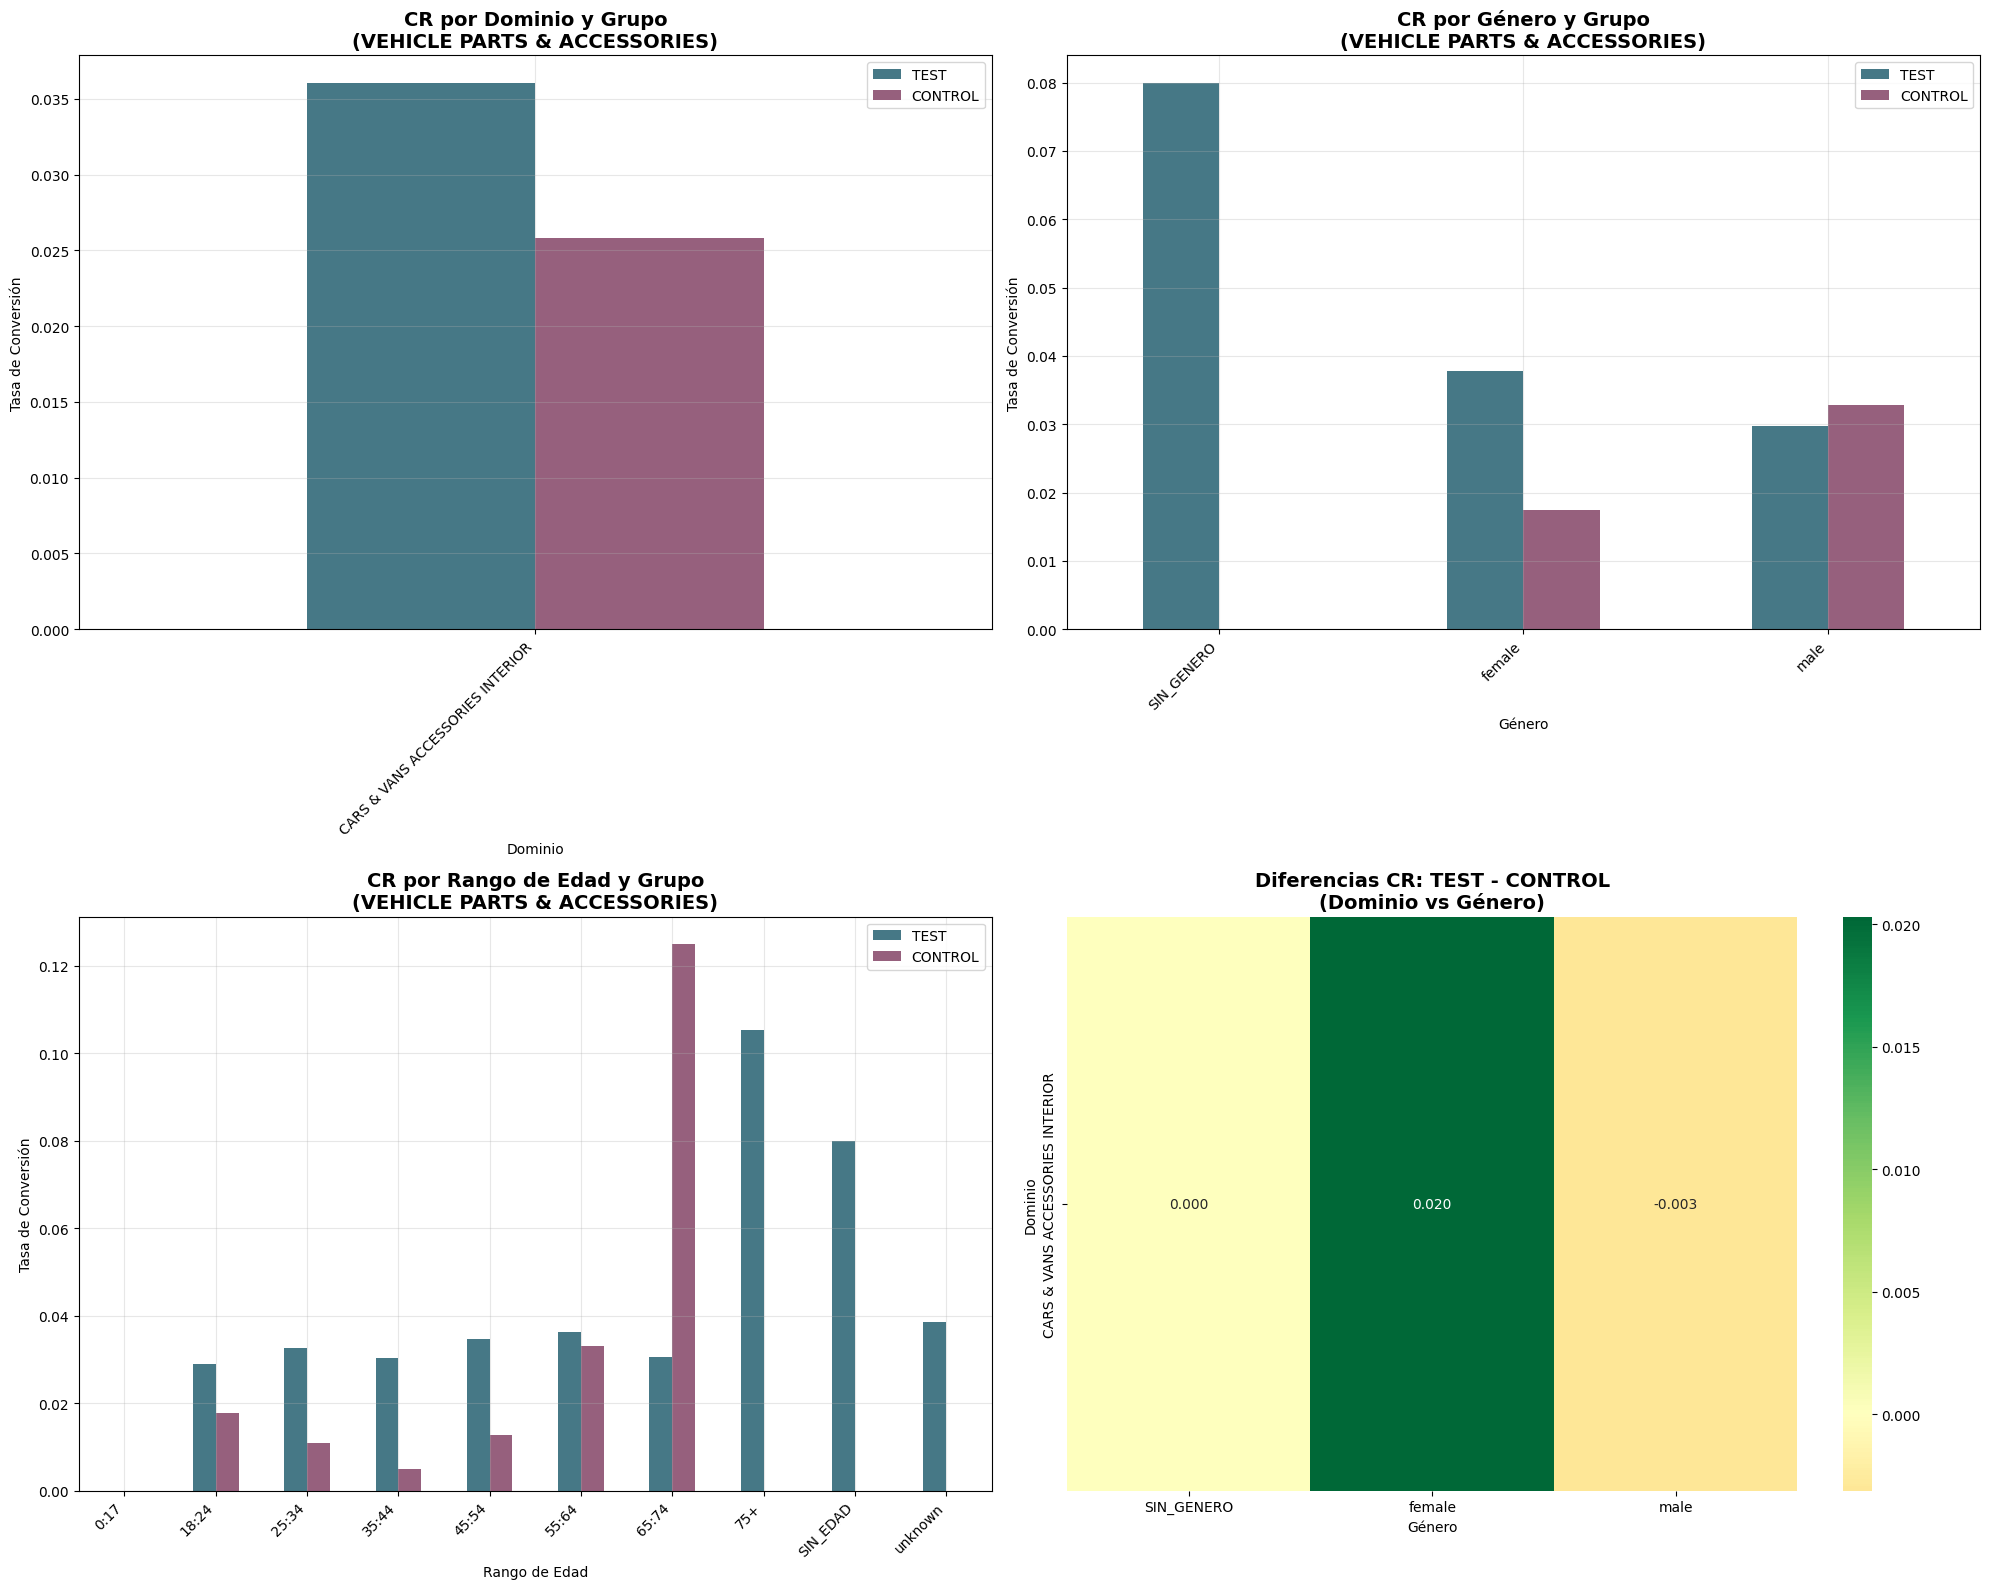


🧪 TESTS DE SIGNIFICANCIA ESTADÍSTICA - VEHICLE PARTS & ACCESSORIES:
--------------------------------------------------------------------------------
�� CARS & VANS ACCESSORIES INTERIOR | female | 45:54:
   TEST: 23/620 (0.037) | CONTROL: 0/49 (0.000)
   Diferencia: 0.037 (3.71pp) | IC95: [0.022, 0.052] | p=1.02e-06 ***
�� CARS & VANS ACCESSORIES INTERIOR | female | 35:44:
   TEST: 31/891 (0.035) | CONTROL: 0/82 (0.000)
   Diferencia: 0.035 (3.48pp) | IC95: [0.023, 0.047] | p=1.45e-08 ***
�� CARS & VANS ACCESSORIES INTERIOR | female | 25:34:
   TEST: 38/967 (0.039) | CONTROL: 1/86 (0.012)
   Diferencia: 0.028 (2.77pp) | IC95: [0.002, 0.053] | p=0.0352 *
�� CARS & VANS ACCESSORIES INTERIOR | male | 35:44:
   TEST: 48/1855 (0.026) | CONTROL: 2/206 (0.010)
   Diferencia: 0.016 (1.62pp) | IC95: [0.001, 0.031] | p=0.0373 *
�� CARS & VANS ACCESSORIES INTERIOR | male | 25:34:
   TEST: 44/1689 (0.026) | CONTROL: 2/193 (0.010)
   Diferencia: 0.016 (1.57pp) | IC95: [-0.000, 0.032] | p=0.0574 
��

In [ ]:
# =======================
# ANÁLISIS CR VEHICLE PARTS & ACCESSORIES
# =======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

print("\n" + "="*80)
print("🚗 ANÁLISIS CR VEHICLE PARTS & ACCESSORIES - DOMINIOS ESPECÍFICOS")
print("="*80)


print("📋 Verificando columnas disponibles...")
print("   Columnas en el DataFrame:", df.columns.tolist())
print("   Shape del DataFrame:", df.shape)


user_cols = [col for col in df.columns if 'CUS' in col.upper() or 'USER' in col.upper() or 'ID' in col.upper()]
print(f"   Columnas de usuario encontradas: {user_cols}")

if user_cols:
    USER_COL = user_cols[0]
    print(f"   Usando columna de usuario: {USER_COL}")
else:
    USER_COL = 'index'
    df = df.reset_index()
    print(f"   No se encontró columna de usuario, usando índice")


print(f"\n📊 Verticales disponibles:")
verticales = df['VERTICAL'].unique()
print(f"   {verticales}")


target_vertical = 'VEHICLE PARTS & ACCESSORIES'
print(f"\n�� Filtrando vertical: '{target_vertical}'")

if target_vertical not in verticales:
    print(f"❌ No se encontró la vertical '{target_vertical}'")
    print("   Verticales disponibles:", verticales)
    exit()

df_vehicle = df[df['VERTICAL'] == target_vertical].copy()
print(f"   Registros VEHICLE PARTS & ACCESSORIES: {len(df_vehicle):,}")
print(f"   Usuarios únicos VEHICLE PARTS & ACCESSORIES: {df_vehicle[USER_COL].nunique():,}")


required_cols = ['DOM_DOMAIN_AGG3', 'GMV_USD', 'GRUPO', 'QTY_ORDERS', 'genero', 'rango_edad']
missing_cols = [col for col in required_cols if col not in df_vehicle.columns]
if missing_cols:
    print(f"❌ Columnas faltantes: {missing_cols}")
    print("   Columnas disponibles:", df_vehicle.columns.tolist())
    exit()


print("\n�� Filtrando dominios específicos...")
target_domains = ['CARS & VANS ACCESSORIES INTERIOR', 'VEHICLE PARTS & ACCESSORIES']
print(f"   Dominios objetivo: {target_domains}")


available_domains = df_vehicle['DOM_DOMAIN_AGG3'].unique()
print(f"   Dominios disponibles en {target_vertical}: {len(available_domains)}")
print(f"   Primeras 10: {available_domains[:10]}")


df_filtered = df_vehicle[df_vehicle['DOM_DOMAIN_AGG3'].isin(target_domains)].copy()
print(f"   Registros después del filtro: {len(df_filtered):,}")
print(f"   Usuarios únicos después del filtro: {df_filtered[USER_COL].nunique():,}")

if len(df_filtered) == 0:
    print("❌ No se encontraron datos para los dominios especificados")
    print("   Dominios disponibles:", available_domains)
    exit()


print("\n🔧 Preparando datos...")
df_clean = df_filtered.copy()


df_clean['DOM_DOMAIN_AGG3'] = df_clean['DOM_DOMAIN_AGG3'].fillna('SIN_DOMINIO')
df_clean['DOM_DOMAIN_AGG3'] = df_clean['DOM_DOMAIN_AGG3'].astype(str).str.strip()


df_clean['genero'] = df_clean['genero'].fillna('SIN_GENERO')
df_clean['genero'] = df_clean['genero'].astype(str).str.strip()


df_clean['rango_edad'] = df_clean['rango_edad'].fillna('SIN_EDAD')
df_clean['rango_edad'] = df_clean['rango_edad'].astype(str).str.strip()


df_clean['GMV_USD'] = pd.to_numeric(df_clean['GMV_USD'], errors='coerce').fillna(0)

print(f"   Dominios únicos: {df_clean['DOM_DOMAIN_AGG3'].nunique()}")
print(f"   Géneros únicos: {df_clean['genero'].nunique()}")
print(f"   Rangos de edad únicos: {df_clean['rango_edad'].nunique()}")
print(f"   GMV_USD total: ${df_clean['GMV_USD'].sum():,.2f}")


print("\n📊 Calculando CR por usuario...")
df_users = (df_clean.assign(conv=(df_clean['QTY_ORDERS'].fillna(0) > 0))
            .groupby([USER_COL, 'GRUPO', 'DOM_DOMAIN_AGG3', 'genero', 'rango_edad'], as_index=False)['conv'].max())

print(f"   Usuarios únicos después de groupby: {df_users[USER_COL].nunique():,}")


print("\n📈 Agregando métricas por todas las dimensiones...")
cr_by_dimensions = (df_users.groupby(['GRUPO', 'DOM_DOMAIN_AGG3', 'genero', 'rango_edad'])
                    .agg(
                        n_users=(USER_COL, 'nunique'),
                        n_conv=('conv', 'sum'),
                        cr=('conv', 'mean')
                    )
                    .reset_index())

print(f"   Combinaciones únicas: {len(cr_by_dimensions)}")


min_users = 20  
cr_filtered = cr_by_dimensions[cr_by_dimensions['n_users'] >= min_users].copy()
print(f"   Combinaciones con >= {min_users} usuarios: {len(cr_filtered)}")

if len(cr_filtered) == 0:
    print("❌ No hay combinaciones con suficiente muestra")
    print("   Reduciendo el mínimo a 5 usuarios...")
    min_users = 5
    cr_filtered = cr_by_dimensions[cr_by_dimensions['n_users'] >= min_users].copy()
    print(f"   Combinaciones con >= {min_users} usuarios: {len(cr_filtered)}")


print("\n📋 TABLA DE RESULTADOS - VEHICLE PARTS & ACCESSORIES:")
print("-" * 80)
display_df = cr_filtered.copy()
display_df['cr_pct'] = (display_df['cr'] * 100).round(2)
display_df['n_conv'] = display_df['n_conv'].astype(int)
display_df['n_users'] = display_df['n_users'].astype(int)


display_df = display_df.sort_values(['GRUPO', 'DOM_DOMAIN_AGG3', 'genero', 'cr'], ascending=[True, True, True, False])
print(display_df[['GRUPO', 'DOM_DOMAIN_AGG3', 'genero', 'rango_edad', 'n_users', 'n_conv', 'cr_pct']].to_string(index=False))


print("\n CREANDO PIVOT PARA ANÁLISIS...")
pivot_cr = cr_filtered.pivot_table(
    index=['DOM_DOMAIN_AGG3', 'genero', 'rango_edad'], 
    columns='GRUPO', 
    values='cr', 
    aggfunc='mean'
)

pivot_users = cr_filtered.pivot_table(
    index=['DOM_DOMAIN_AGG3', 'genero', 'rango_edad'], 
    columns='GRUPO', 
    values='n_users', 
    aggfunc='sum'
)


if 'TEST' in pivot_cr.columns and 'CONTROL' in pivot_cr.columns:
    pivot_cr['DIFERENCIA'] = pivot_cr['TEST'] - pivot_cr['CONTROL']
    pivot_cr['DIFERENCIA_PCT'] = ((pivot_cr['TEST'] - pivot_cr['CONTROL']) / pivot_cr['CONTROL'] * 100).round(2)
    
    # Ordenar por diferencia
    pivot_cr = pivot_cr.sort_values('DIFERENCIA', ascending=False)
    
    print("\n🎯 DIFERENCIAS TEST vs CONTROL - VEHICLE PARTS & ACCESSORIES:")
    print("-" * 80)
    diff_display = pivot_cr[['TEST', 'CONTROL', 'DIFERENCIA', 'DIFERENCIA_PCT']].copy()
    diff_display['TEST'] = (diff_display['TEST'] * 100).round(2)
    diff_display['CONTROL'] = (diff_display['CONTROL'] * 100).round(2)
    diff_display['DIFERENCIA'] = (diff_display['DIFERENCIA'] * 100).round(2)
    print(diff_display.head(20).to_string())


print("\n📈 CREANDO GRÁFICOS...")

# Gráfico: CR por dominio y grupo
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# Gráfico: CR por dominio
if 'TEST' in pivot_cr.columns and 'CONTROL' in pivot_cr.columns:
    # Agregar por dominio
    cr_by_domain = cr_filtered.groupby(['DOM_DOMAIN_AGG3', 'GRUPO']).agg({
        'n_users': 'sum',
        'n_conv': 'sum',
        'cr': 'mean'
    }).reset_index()
    
    pivot_domain = cr_by_domain.pivot(index='DOM_DOMAIN_AGG3', columns='GRUPO', values='cr')
    pivot_domain[['TEST', 'CONTROL']].plot(kind='bar', ax=ax1, color=['#467886ff', '#96607dff'])
    ax1.set_title('CR por Dominio y Grupo\n(VEHICLE PARTS & ACCESSORIES)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Tasa de Conversión')
    ax1.set_xlabel('Dominio')
    ax1.grid(True, alpha=0.3)
    ax1.legend(['TEST', 'CONTROL'])
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# Gráfico: CR por género
cr_by_gender = cr_filtered.groupby(['genero', 'GRUPO']).agg({
    'n_users': 'sum',
    'n_conv': 'sum',
    'cr': 'mean'
}).reset_index()

pivot_gender = cr_by_gender.pivot(index='genero', columns='GRUPO', values='cr')
if 'TEST' in pivot_gender.columns and 'CONTROL' in pivot_gender.columns:
    pivot_gender[['TEST', 'CONTROL']].plot(kind='bar', ax=ax2, color=['#467886ff', '#96607dff'])
    ax2.set_title('CR por Género y Grupo\n(VEHICLE PARTS & ACCESSORIES)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Tasa de Conversión')
    ax2.set_xlabel('Género')
    ax2.grid(True, alpha=0.3)
    ax2.legend(['TEST', 'CONTROL'])
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# Gráfico: CR por rango de edad
cr_by_age = cr_filtered.groupby(['rango_edad', 'GRUPO']).agg({
    'n_users': 'sum',
    'n_conv': 'sum',
    'cr': 'mean'
}).reset_index()

pivot_age = cr_by_age.pivot(index='rango_edad', columns='GRUPO', values='cr')
if 'TEST' in pivot_age.columns and 'CONTROL' in pivot_age.columns:
    pivot_age[['TEST', 'CONTROL']].plot(kind='bar', ax=ax3, color=['#467886ff', '#96607dff'])
    ax3.set_title('CR por Rango de Edad y Grupo\n(VEHICLE PARTS & ACCESSORIES)', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Tasa de Conversión')
    ax3.set_xlabel('Rango de Edad')
    ax3.grid(True, alpha=0.3)
    ax3.legend(['TEST', 'CONTROL'])
    plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')

# Gráfico: Heatmap de diferencias
if 'DIFERENCIA' in pivot_cr.columns:
    
    heatmap_data = cr_filtered.groupby(['DOM_DOMAIN_AGG3', 'genero', 'GRUPO']).agg({
        'n_users': 'sum',
        'n_conv': 'sum',
        'cr': 'mean'
    }).reset_index()
    
    heatmap_pivot = heatmap_data.pivot_table(
        index=['DOM_DOMAIN_AGG3', 'genero'], 
        columns='GRUPO', 
        values='cr'
    )
    
    if 'TEST' in heatmap_pivot.columns and 'CONTROL' in heatmap_pivot.columns:
       
        heatmap_pivot['DIFERENCIA'] = heatmap_pivot['TEST'] - heatmap_pivot['CONTROL']
        
 
        diff_matrix = heatmap_pivot['DIFERENCIA'].unstack()
        
        
        diff_matrix = diff_matrix.fillna(0)
        diff_matrix = diff_matrix.replace([np.inf, -np.inf], 0)
        
      
        try:
            diff_matrix = diff_matrix.astype(float)
        except Exception as e:
            print(f"⚠️ Error convirtiendo a float: {e}")
          
            diff_matrix = pd.DataFrame(0, index=diff_matrix.index, columns=diff_matrix.columns)
        
      
        if not diff_matrix.empty and diff_matrix.notna().any().any() and diff_matrix.dtypes.apply(lambda x: pd.api.types.is_numeric_dtype(x)).all():
       
            sns.heatmap(diff_matrix, 
                       annot=True, fmt='.3f', cmap='RdYlGn', center=0, ax=ax4)
            ax4.set_title('Diferencias CR: TEST - CONTROL\n(Dominio vs Género)', fontsize=14, fontweight='bold')
            ax4.set_xlabel('Género')
            ax4.set_ylabel('Dominio')
        else:
          
            ax4.text(0.5, 0.5, 'No hay datos válidos\npara el heatmap', 
                    ha='center', va='center', transform=ax4.transAxes, fontsize=12)
            ax4.set_title('Diferencias CR: TEST - CONTROL\n(Dominio vs Género)', fontsize=14, fontweight='bold')
            ax4.set_xlabel('Género')
            ax4.set_ylabel('Dominio')
    else:
      
        ax4.text(0.5, 0.5, 'No hay datos de TEST/CONTROL\npara el heatmap', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=12)
        ax4.set_title('Diferencias CR: TEST - CONTROL\n(Dominio vs Género)', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Género')
        ax4.set_ylabel('Dominio')

plt.tight_layout()
plt.show()

#  Test de significancia estadística
print("\n🧪 TESTS DE SIGNIFICANCIA ESTADÍSTICA - VEHICLE PARTS & ACCESSORIES:")
print("-" * 80)

if 'TEST' in pivot_cr.columns and 'CONTROL' in pivot_cr.columns:
    for idx, row in pivot_cr.iterrows():
        if pd.notna(row['TEST']) and pd.notna(row['CONTROL']):
          
            domain, gender, age = idx
            combination_data = cr_filtered[
                (cr_filtered['DOM_DOMAIN_AGG3'] == domain) &
                (cr_filtered['genero'] == gender) &
                (cr_filtered['rango_edad'] == age)
            ]
            
            if len(combination_data) == 2:  # Ambos grupos presentes
                test_data = combination_data[combination_data['GRUPO'] == 'TEST'].iloc[0]
                control_data = combination_data[combination_data['GRUPO'] == 'CONTROL'].iloc[0]
                
                n1, x1 = test_data['n_users'], test_data['n_conv']
                n0, x0 = control_data['n_users'], control_data['n_conv']
                
                p1, p0 = x1/n1, x0/n0
                se = np.sqrt(p1*(1-p1)/n1 + p0*(1-p0)/n0)
                diff = p1 - p0
                z = 0 if se == 0 else diff/se
                pval = 2*(1 - stats.norm.cdf(abs(z)))
                ci = (diff - 1.96*se, diff + 1.96*se)
                
                significance = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else ""
                
                print(f"�� {domain} | {gender} | {age}:")
                print(f"   TEST: {x1}/{n1} ({p1:.3f}) | CONTROL: {x0}/{n0} ({p0:.3f})")
                print(f"   Diferencia: {diff:.3f} ({diff*100:.2f}pp) | IC95: [{ci[0]:.3f}, {ci[1]:.3f}] | p={pval:.3g} {significance}")


print("\n" + "="*80)
print("📊 RESUMEN EJECUTIVO - VEHICLE PARTS & ACCESSORIES")
print("="*80)

if 'DIFERENCIA' in pivot_cr.columns:

    diff_clean = pivot_cr['DIFERENCIA'].dropna()
    
    if len(diff_clean) > 0:
    
        total_combinations = len(diff_clean)
        positive_diffs = len(diff_clean[diff_clean > 0])
        negative_diffs = len(diff_clean[diff_clean < 0])
        
        avg_diff = diff_clean.mean()
        max_diff = diff_clean.max()
        min_diff = diff_clean.min()
        
        print(f"�� COMBINACIONES ANALIZADAS: {total_combinations}")
        print(f"📈 DIFERENCIAS POSITIVAS: {positive_diffs} ({positive_diffs/total_combinations*100:.1f}%)")
        print(f"📉 DIFERENCIAS NEGATIVAS: {negative_diffs} ({negative_diffs/total_combinations*100:.1f}%)")
        print(f"📊 DIFERENCIA PROMEDIO: {avg_diff:.3f} ({avg_diff*100:.2f}pp)")
        print(f"🔝 MEJOR DIFERENCIA: {max_diff:.3f} ({max_diff*100:.2f}pp)")
        print(f"🔻 PEOR DIFERENCIA: {min_diff:.3f} ({min_diff*100:.2f}pp)")
        
        # Top 3 combinaciones con mejor performance
        top_3 = diff_clean.nlargest(3)
        print(f"\n🏆 TOP 3 COMBINACIONES CON MEJOR PERFORMANCE:")
        for i, (idx, diff) in enumerate(top_3.items(), 1):
            domain, gender, age = idx
            print(f"   {i}. {domain} | {gender} | {age}: +{diff:.3f} ({diff*100:.2f}pp)")
    else:
        print("❌ No hay diferencias válidas para calcular estadísticas")


print("\n💾 EXPORTANDO DATOS DE GRÁFICOS PARA HERRAMIENTAS EXTERNAS...")
timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")

# =========================
# GRÁFICO : CR POR DOMINIO Y GRUPO
# =========================
if 'TEST' in pivot_cr.columns and 'CONTROL' in pivot_cr.columns:
  
    chart1_data = pivot_domain[['TEST', 'CONTROL']].copy()
    chart1_data['TEST_PCT'] = (chart1_data['TEST'] * 100).round(2)
    chart1_data['CONTROL_PCT'] = (chart1_data['CONTROL'] * 100).round(2)
    chart1_data['DIFERENCIA_ABSOLUTA'] = (chart1_data['TEST'] - chart1_data['CONTROL']).round(4)
    chart1_data['DIFERENCIA_PORCENTUAL'] = ((chart1_data['TEST'] - chart1_data['CONTROL']) / chart1_data['CONTROL'] * 100).round(2)
    
    chart1_data['DOMINIO'] = chart1_data.index
    chart1_data = chart1_data.reset_index(drop=True)
    
    chart1_data = chart1_data[['DOMINIO', 'TEST', 'CONTROL', 'TEST_PCT', 'CONTROL_PCT', 
                              'DIFERENCIA_ABSOLUTA', 'DIFERENCIA_PORCENTUAL']]
    
    chart1_filename = f"grafico1_cr_por_dominio_vehicle_{timestamp}.csv"
    chart1_data.to_csv(chart1_filename, index=False)
    print(f"✅ Gráfico 1 - CR por Dominio: {chart1_filename}")

# =========================
# GRÁFICO : CR POR GÉNERO Y GRUPO
# =========================
if 'TEST' in pivot_gender.columns and 'CONTROL' in pivot_gender.columns:
    chart2_data = pivot_gender[['TEST', 'CONTROL']].copy()
    chart2_data['TEST_PCT'] = (chart2_data['TEST'] * 100).round(2)
    chart2_data['CONTROL_PCT'] = (chart2_data['CONTROL'] * 100).round(2)
    chart2_data['DIFERENCIA_ABSOLUTA'] = (chart2_data['TEST'] - chart2_data['CONTROL']).round(4)
    chart2_data['DIFERENCIA_PORCENTUAL'] = ((chart2_data['TEST'] - chart2_data['CONTROL']) / chart2_data['CONTROL'] * 100).round(2)
    
    chart2_data['GENERO'] = chart2_data.index
    chart2_data = chart2_data.reset_index(drop=True)
    
    chart2_data = chart2_data[['GENERO', 'TEST', 'CONTROL', 'TEST_PCT', 'CONTROL_PCT', 
                              'DIFERENCIA_ABSOLUTA', 'DIFERENCIA_PORCENTUAL']]
    
    chart2_filename = f"grafico2_cr_por_genero_vehicle_{timestamp}.csv"
    chart2_data.to_csv(chart2_filename, index=False)
    print(f"✅ Gráfico 2 - CR por Género: {chart2_filename}")

# =========================
# GRÁFICO : CR POR RANGO DE EDAD Y GRUPO
# =========================
if 'TEST' in pivot_age.columns and 'CONTROL' in pivot_age.columns:
    chart3_data = pivot_age[['TEST', 'CONTROL']].copy()
    chart3_data['TEST_PCT'] = (chart3_data['TEST'] * 100).round(2)
    chart3_data['CONTROL_PCT'] = (chart3_data['CONTROL'] * 100).round(2)
    chart3_data['DIFERENCIA_ABSOLUTA'] = (chart3_data['TEST'] - chart3_data['CONTROL']).round(4)
    chart3_data['DIFERENCIA_PORCENTUAL'] = ((chart3_data['TEST'] - chart3_data['CONTROL']) / chart3_data['CONTROL'] * 100).round(2)
    
    chart3_data['RANGO_EDAD'] = chart3_data.index
    chart3_data = chart3_data.reset_index(drop=True)
    
    chart3_data = chart3_data[['RANGO_EDAD', 'TEST', 'CONTROL', 'TEST_PCT', 'CONTROL_PCT', 
                              'DIFERENCIA_ABSOLUTA', 'DIFERENCIA_PORCENTUAL']]
    
    chart3_filename = f"grafico3_cr_por_edad_vehicle_{timestamp}.csv"
    chart3_data.to_csv(chart3_filename, index=False)
    print(f"✅ Gráfico 3 - CR por Rango de Edad: {chart3_filename}")

# =========================
# GRÁFICO : DATOS DETALLADOS POR COMBINACIÓN
# =========================
chart4_data = []
for idx, row in pivot_cr.iterrows():
    if pd.notna(row['TEST']) and pd.notna(row['CONTROL']):
        domain, gender, age = idx
        combination_data = cr_filtered[
            (cr_filtered['DOM_DOMAIN_AGG3'] == domain) &
            (cr_filtered['genero'] == gender) &
            (cr_filtered['rango_edad'] == age)
        ]
        
        if len(combination_data) == 2:
            test_data = combination_data[combination_data['GRUPO'] == 'TEST'].iloc[0]
            control_data = combination_data[combination_data['GRUPO'] == 'CONTROL'].iloc[0]
            
            chart4_data.append({
                'DOMINIO': domain,
                'GENERO': gender,
                'RANGO_EDAD': age,
                'TEST_USERS': test_data['n_users'],
                'TEST_CONV': test_data['n_conv'],
                'TEST_CR': test_data['cr'],
                'TEST_CR_PCT': test_data['cr'] * 100,
                'CONTROL_USERS': control_data['n_users'],
                'CONTROL_CONV': control_data['n_conv'],
                'CONTROL_CR': control_data['cr'],
                'CONTROL_CR_PCT': control_data['cr'] * 100,
                'DIFERENCIA_ABSOLUTA': test_data['cr'] - control_data['cr'],
                'DIFERENCIA_PORCENTUAL': ((test_data['cr'] - control_data['cr']) / control_data['cr'] * 100) if control_data['cr'] > 0 else 0
            })

if chart4_data:
    chart4_df = pd.DataFrame(chart4_data)
    chart4_df = chart4_df.round(4)
    chart4_filename = f"grafico4_datos_detallados_vehicle_{timestamp}.csv"
    chart4_df.to_csv(chart4_filename, index=False)
    print(f"✅ Gráfico 4 - Datos Detallados por Combinación: {chart4_filename}")

# =========================
# RESUMEN DE ARCHIVOS EXPORTADOS
# =========================
print(f"\n📋 RESUMEN DE ARCHIVOS EXPORTADOS:")
print("-" * 80)
print(f"�� ARCHIVOS PARA GRÁFICOS:")
print(f"   1. {chart1_filename} - CR por Dominio")
print(f"   2. {chart2_filename} - CR por Género")
print(f"   3. {chart3_filename} - CR por Rango de Edad")
print(f"   4. {chart4_filename} - Datos Detallados por Combinación")

print(f"\n💡 INSTRUCCIONES PARA USAR EN OTRAS HERRAMIENTAS:")
print(f"   • Excel/PowerBI: Importa los archivos CSV directamente")
print(f"   • Tableau: Usa 'Text File' como fuente de datos")
print(f"   • Python: pd.read_csv('{chart1_filename}')")
print(f"   • R: read.csv('{chart1_filename}')")


print("\n💾 EXPORTANDO RESULTADOS ADICIONALES...")

cr_filtered.to_csv(f"cr_vehicle_parts_accessories_{timestamp}.csv", index=False)
print(f"✅ Tabla completa guardada: cr_vehicle_parts_accessories_{timestamp}.csv")


if 'TEST' in pivot_cr.columns and 'CONTROL' in pivot_cr.columns:
    pivot_cr.to_csv(f"cr_pivot_vehicle_parts_accessories_{timestamp}.csv")
    print(f"✅ Pivot guardado: cr_pivot_vehicle_parts_accessories_{timestamp}.csv")

print(f"\n✅ Análisis completado exitosamente!")
print("="*80)

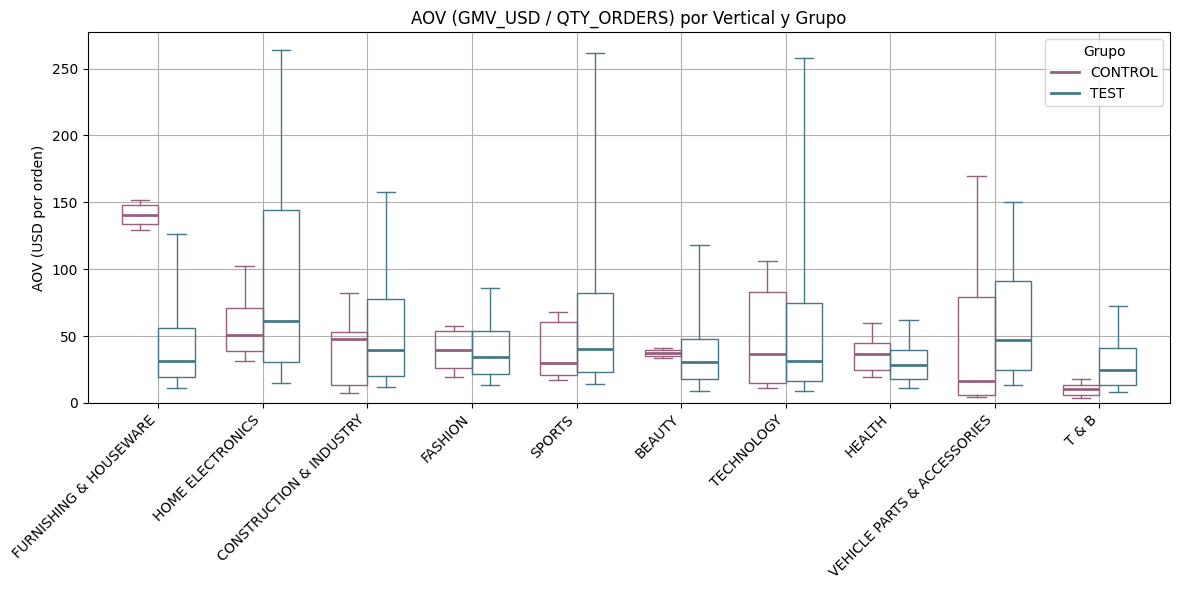

✅ Exportado (long): C:\Users\ctattoli\Downloads\aov_boxplot_long.csv  -> 20 filas
✅ Exportado (wide): C:\Users\ctattoli\Downloads\aov_boxplot_wide.csv  -> 10 filas, 11 columnas


In [ ]:
# =========================
# Boxplot AOV (GMV/QTY) por VERTICAL y GRUPO
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


csv_path = r"C:\Users\ctattoli\Downloads\export_20250903_215824.csv"  
GRUPO_CONTROL = "CONTROL"
GRUPO_TEST    = "TEST"
COLOR_TEST    = "#467886ff"
COLOR_CONTROL = "#96607dff"
ORDER_BY      = "median"     
TOPN          = None         
YSCALE        = "linear"    
YMIN          = 0            


df = pd.read_csv(csv_path)
df.columns = [c.strip().upper() for c in df.columns]


VERT_COL = "VERTICAL" if "VERTICAL" in df.columns else ("VERTICAL_K" if "VERTICAL_K" in df.columns else None)
if VERT_COL is None:
    raise ValueError("No encuentro columna de VERTICAL (esperaba 'VERTICAL' o 'VERTICAL_K') en el CSV.")

if "GRUPO" not in df.columns:
    raise ValueError("No encuentro columna 'GRUPO' en el CSV.")


needed = ["P50", "P75"]
for c in needed:
    if c not in df.columns:
        raise ValueError(f"El CSV debe incluir al menos {needed}. Faltó: {c}")


warns = []
if "P25" not in df.columns:
    df["P25"] = df["P50"]; warns.append("⚠️ Falta P25 -> uso P50 como Q1 (aprox). Recomendado recalcular P25 real.")
if "P10" not in df.columns:
    df["P10"] = df["P25"]; warns.append("ℹ️ Falta P10 -> uso P25 como whisker inferior.")
if "P90" not in df.columns:
    df["P90"] = df["P75"]; warns.append("ℹ️ Falta P90 -> uso P75 como whisker superior.")
if warns: print("\n".join(warns))


for c in ["P10","P25","P50","P75","P90","COUNT","MEAN"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df = df[df["GRUPO"].isin([GRUPO_CONTROL, GRUPO_TEST])].copy()
vert_has_control = set(df.loc[df["GRUPO"]==GRUPO_CONTROL, VERT_COL].unique())
vert_has_test    = set(df.loc[df["GRUPO"]==GRUPO_TEST,    VERT_COL].unique())
valid_verts = sorted(list(vert_has_control & vert_has_test))
if not valid_verts:
    raise ValueError("No hay verticales con datos en ambos grupos tras filtrar Control/Test.")


if TOPN is not None:
    if ORDER_BY == "median":
        med_by_v = (df.pivot_table(index=VERT_COL, columns="GRUPO", values="P50", aggfunc="first")
                      .loc[valid_verts]
                      .mean(axis=1)
                      .sort_values(ascending=False))
        valid_verts = med_by_v.index[:TOPN].tolist()
    else:
        if "COUNT" in df.columns:
            cnt_by_v = (df.groupby(VERT_COL)["COUNT"].sum().loc[valid_verts]
                        .sort_values(ascending=False))
        else:
            cnt_by_v = (df.groupby(VERT_COL).size().loc[valid_verts]
                        .sort_values(ascending=False))
        valid_verts = cnt_by_v.index[:TOPN].tolist()


if ORDER_BY == "median":
    med_by_v = (df.pivot_table(index=VERT_COL, columns="GRUPO", values="P50", aggfunc="first")
                  .loc[valid_verts]
                  .mean(axis=1)
                  .sort_values(ascending=False))
    order = med_by_v.index.tolist()
else:
    if "COUNT" in df.columns:
        cnt_by_v = (df.groupby(VERT_COL)["COUNT"].sum().loc[valid_verts]
                    .sort_values(ascending=False))
    else:
        cnt_by_v = (df.groupby(VERT_COL).size().loc[valid_verts]
                    .sort_values(ascending=False))
    order = cnt_by_v.index.tolist()


def build_boxes(df_group, verts_order):
    boxes, positions, labels = [], [], []
    for i, v in enumerate(verts_order):
        row = df_group[df_group[VERT_COL]==v]
        if len(row)==0:
            continue
        r = row.iloc[0]
        q1, med, q3 = float(r["P25"]), float(r["P50"]), float(r["P75"])
        lo, hi = float(r["P10"]), float(r["P90"])
        
        lo = min(lo, q1)
        hi = max(hi, q3)
        boxes.append({"med":med, "q1":q1, "q3":q3, "whislo":lo, "whishi":hi, "fliers":[]})
        positions.append(i)
        labels.append(v)
    return boxes, positions, labels

df_c = df[df["GRUPO"]==GRUPO_CONTROL]
df_t = df[df["GRUPO"]==GRUPO_TEST]

boxes_c, pos_c, _ = build_boxes(df_c, order)
boxes_t, pos_t, _ = build_boxes(df_t, order)


keep_idx = sorted(set(pos_c) & set(pos_t))
def subset_boxes(boxes, pos_list, keep):
    m = {p:i for i,p in enumerate(pos_list)}
    out = [boxes[m[p]] for p in keep]
    return out, keep

boxes_c, pos_c = subset_boxes(boxes_c, pos_c, keep_idx)
boxes_t, pos_t = subset_boxes(boxes_t, pos_t, keep_idx)
xlabels = [order[i] for i in keep_idx]
xpos_center = np.arange(len(keep_idx))
w = 0.35
xpos_ctrl = xpos_center - w/2
xpos_test = xpos_center + w/2

# ----------- Plot -----------
fig, ax = plt.subplots(figsize=(12, 6))


ax.bxp(
    boxes_c, positions=xpos_ctrl, widths=w, showfliers=False, patch_artist=True,
    boxprops=dict(facecolor="none", edgecolor=COLOR_CONTROL),
    medianprops=dict(color=COLOR_CONTROL, linewidth=2),
    whiskerprops=dict(color=COLOR_CONTROL),
    capprops=dict(color=COLOR_CONTROL)
)
ax.bxp(
    boxes_t, positions=xpos_test, widths=w, showfliers=False, patch_artist=True,
    boxprops=dict(facecolor="none", edgecolor=COLOR_TEST),
    medianprops=dict(color=COLOR_TEST, linewidth=2),
    whiskerprops=dict(color=COLOR_TEST),
    capprops=dict(color=COLOR_TEST)
)

ax.set_xticks(xpos_center)
ax.set_xticklabels(xlabels, rotation=45, ha="right")
ax.set_title("AOV (GMV_USD / QTY_ORDERS) por Vertical y Grupo")
ax.set_ylabel("AOV (USD por orden)")
ax.grid(True, axis="y")


ax.set_yscale(YSCALE)
ax.set_ylim(bottom=YMIN)


legend_elems = [
    Line2D([0],[0], color=COLOR_CONTROL, lw=2, label=GRUPO_CONTROL),
    Line2D([0],[0], color=COLOR_TEST,    lw=2, label=GRUPO_TEST),
]
ax.legend(handles=legend_elems, title="Grupo", loc="upper right")

plt.tight_layout()
plt.show()

# =========================
# Exportar datos usados en el gráfico 
# =========================


out_long_path = r"C:\Users\ctattoli\Downloads\aov_boxplot_long.csv"
out_wide_path = r"C:\Users\ctattoli\Downloads\aov_boxplot_wide.csv"

extra_cols = [c for c in ["COUNT", "MEAN"] if c in df.columns]  # opcional si existen
export_cols = [VERT_COL, "GRUPO", "P10", "P25", "P50", "P75", "P90"] + extra_cols


mask = df[VERT_COL].isin(xlabels) & df["GRUPO"].isin([GRUPO_CONTROL, GRUPO_TEST])
df_plot = df.loc[mask, export_cols].copy()


df_plot[VERT_COL] = pd.Categorical(df_plot[VERT_COL], categories=xlabels, ordered=True)
df_plot.sort_values([VERT_COL, "GRUPO"], inplace=True)


df_plot = (df_plot
           .groupby([VERT_COL, "GRUPO"], as_index=False)
           .agg({k: "first" for k in export_cols if k not in [VERT_COL, "GRUPO"]}))


pos_map = {v: i for i, v in enumerate(xlabels)}
df_plot["x_center"] = df_plot[VERT_COL].map(pos_map).astype(float)
df_plot["x_pos"] = np.where(
    df_plot["GRUPO"] == GRUPO_CONTROL,
    df_plot["x_center"] - (w/2),
    df_plot["x_center"] + (w/2)
)


df_plot.to_csv(out_long_path, index=False, encoding="utf-8")
print(f"✅ Exportado (long): {out_long_path}  -> {df_plot.shape[0]} filas")


wide = (df_plot
        .pivot(index=VERT_COL, columns="GRUPO", values=["P10","P25","P50","P75","P90"])
        .sort_index())

wide.columns = [f"{stat}_{grp}" for stat, grp in wide.columns]
wide.reset_index(inplace=True)
wide.to_csv(out_wide_path, index=False, encoding="utf-8")
print(f"✅ Exportado (wide): {out_wide_path}  -> {wide.shape[0]} filas, {wide.shape[1]} columnas")





INSIGHTS

In [ ]:
## ANSLISIS DE CONVERSIÓN


def conversion_analysis(df):
    print("="*60)
    print("ANÁLISIS DE CONVERSIÓN")
    print("="*60)
    

    conversion_metrics = df.groupby('GRUPO').agg({
        'CUS_CUST_ID': 'nunique', 
        'QTY_ORDERS': ['sum', 'mean'],  
        'GMV_USD': ['sum', 'mean'],  
        'ITE_ITEM_ID': 'count' 
    }).round(2)
    
 
    conversion_metrics['conversion_rate'] = (
        conversion_metrics[('QTY_ORDERS', 'sum')] / 
        conversion_metrics[('ITE_ITEM_ID', 'count')]
    ).round(4)
    
    conversion_metrics['gmv_per_view'] = (
        conversion_metrics[('GMV_USD', 'sum')] / 
        conversion_metrics[('ITE_ITEM_ID', 'count')]
    ).round(2)
    
    print("Métricas de conversión por grupo:")
    print(conversion_metrics)
    
    return conversion_metrics


conv_metrics = conversion_analysis(df)

ANÁLISIS DE CONVERSIÓN
Métricas de conversión por grupo:
        CUS_CUST_ID QTY_ORDERS           GMV_USD        ITE_ITEM_ID  \
            nunique        sum  mean         sum   mean       count   
GRUPO                                                                 
CONTROL      142820       4548  0.02   185394.13  42.80      283812   
TEST        1397233      73983  0.03  3545308.87  50.54     2977442   

        conversion_rate gmv_per_view  
                                      
GRUPO                                 
CONTROL           0.016         0.65  
TEST             0.0248         1.19  


In [ ]:
## ANALISIS DE PRECIOS Y DESCUENTOS 

def price_analysis(df):
    print("="*60)
    print("ANÁLISIS DE PRECIOS Y DESCUENTOS")
    print("="*60)
    
   
    df['effective_discount'] = (
        (df['ORIGINAL_PRICE'] - df['ACTUAL_PRICE']) / df['ORIGINAL_PRICE'] * 100
    )
    
    price_comparison = df.groupby('GRUPO').agg({
        'ACTUAL_PRICE': ['mean', 'median', 'std'],
        'ORIGINAL_PRICE': ['mean', 'median', 'std'],
        'effective_discount': ['mean', 'median', 'std'],
        'PROMOTION_DISCOUNT_PCT': ['mean', 'median', 'std'],
        'COUPON_PCT_DISCOUNT': ['mean', 'median', 'std']
    }).round(2)
    
    print("Comparación de precios por grupo:")
    print(price_comparison)
    
    
    from scipy import stats
    test_prices = df[df['GRUPO']=='TEST']['ACTUAL_PRICE']
    control_prices = df[df['GRUPO']=='CONTROL']['ACTUAL_PRICE']
    
    t_stat, p_value = stats.ttest_ind(test_prices, control_prices)
    print(f"\nTest t para diferencia de precios:")
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Diferencia significativa: {'Sí' if p_value < 0.05 else 'No'}")
    
    return price_comparison


price_analysis(df)

ANÁLISIS DE PRECIOS Y DESCUENTOS
Comparación de precios por grupo:
        ACTUAL_PRICE                      ORIGINAL_PRICE                       \
                mean    median        std           mean    median        std   
GRUPO                                                                           
CONTROL    131210.63  49990.00  394041.53      444620.83  645609.0  369161.43   
TEST       112722.68  43386.53  400747.81      134184.75   50900.0  485277.62   

        effective_discount              PROMOTION_DISCOUNT_PCT               \
                      mean median   std                   mean median   std   
GRUPO                                                                         
CONTROL              14.41  11.29  9.93                  14.41  11.29  9.93   
TEST                 14.82  10.73  9.23                  14.82  10.73  9.23   

        COUPON_PCT_DISCOUNT               
                       mean median   std  
GRUPO                                     
CO

ACTUAL_PRICE                      ORIGINAL_PRICE                       \
                mean    median        std           mean    median        std   
GRUPO                                                                           
CONTROL    131210.63  49990.00  394041.53      444620.83  645609.0  369161.43   
TEST       112722.68  43386.53  400747.81      134184.75   50900.0  485277.62   

        effective_discount              PROMOTION_DISCOUNT_PCT               \
                      mean median   std                   mean median   std   
GRUPO                                                                         
CONTROL              14.41  11.29  9.93                  14.41  11.29  9.93   
TEST                 14.82  10.73  9.23                  14.82  10.73  9.23   

        COUPON_PCT_DISCOUNT               
                       mean median   std  
GRUPO                                     
CONTROL                9.01    5.0  5.68  
TEST                   9.08    5.0  5.63

ANÁLISIS TEMPORAL


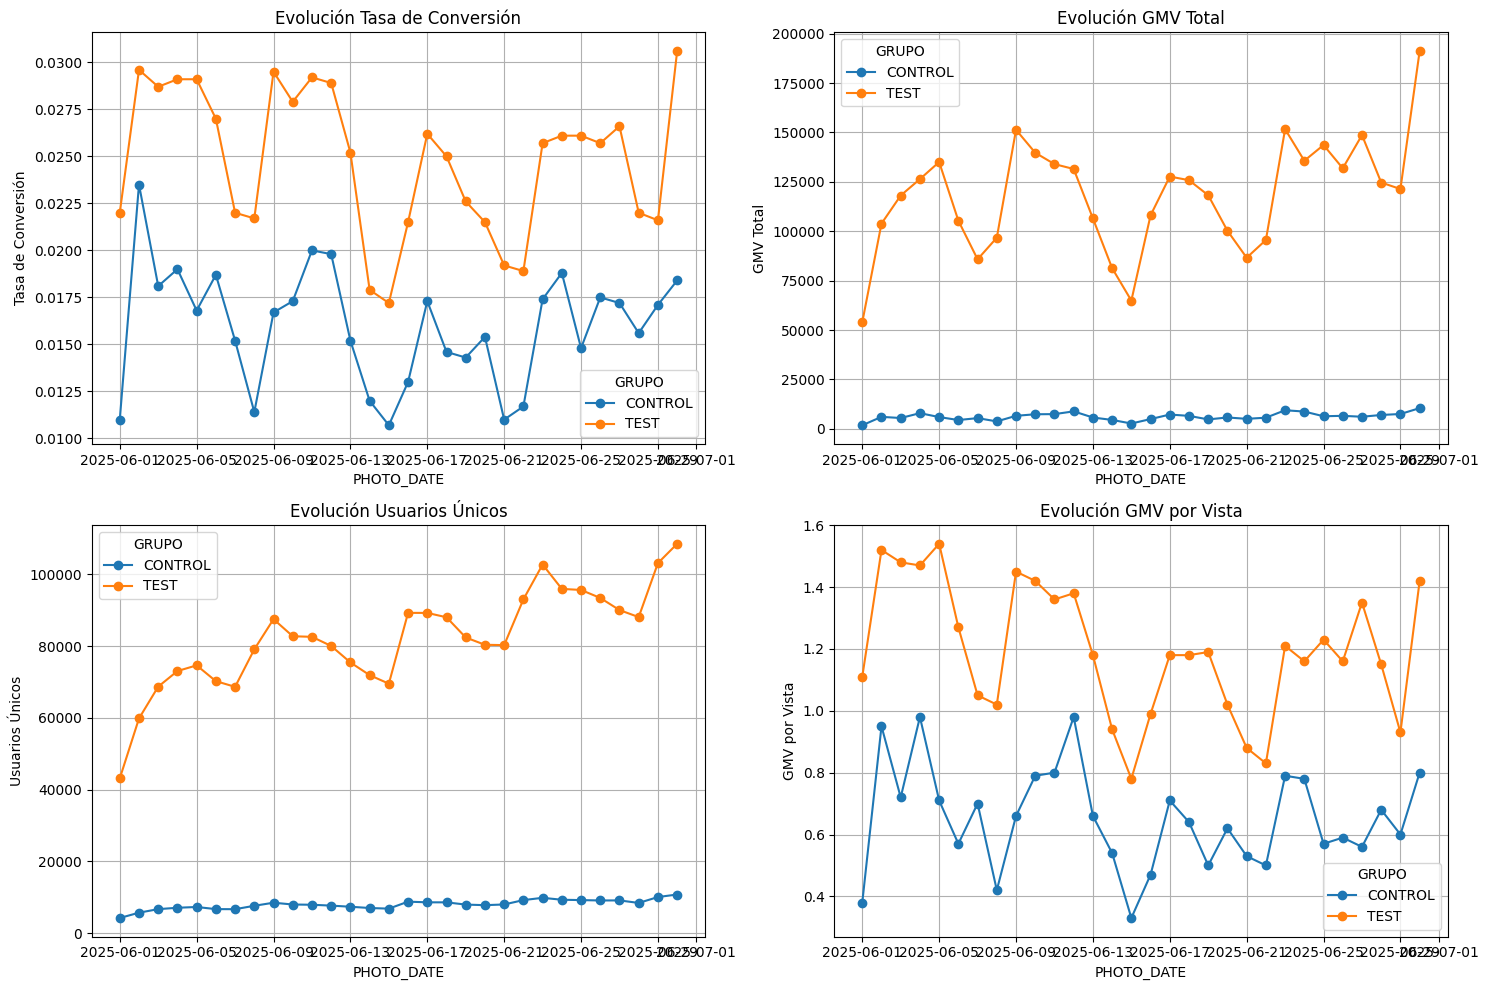

,PHOTO_DATE,GRUPO,CUS_CUST_ID,ITE_ITEM_ID,QTY_ORDERS,GMV_USD,conversion_rate,gmv_per_view
0,2025-06-01,CONTROL,4197,4639,51,1780.447243,0.011,0.38
1,2025-06-01,TEST,43125,48705,1071,53915.068589,0.022,1.11
2,2025-06-02,CONTROL,5684,6384,150,6035.275791,0.0235,0.95
3,2025-06-02,TEST,59848,68517,2026,103868.553236,0.0296,1.52
4,2025-06-03,CONTROL,6670,7608,138,5446.106723,0.0181,0.72
5,2025-06-03,TEST,68721,79955,2297,118083.230430,0.0287,1.48
6,2025-06-04,CONTROL,7056,8059,153,7906.444898,0.019,0.98
7,2025-06-04,TEST,73070,85777,2499,126396.561679,0.0291,1.47
8,2025-06-05,CONTROL,7271,8397,141,5930.277021,0.0168,0.71
9,2025-06-05,TEST,74659,87924,2559,135040.610882,0.0291,1.54


In [ ]:
## ANALISIS TEMPORAL

def temporal_analysis(df):
    print("="*60)
    print("ANÁLISIS TEMPORAL")
    print("="*60)
    
   
    daily_metrics = df.groupby(['PHOTO_DATE', 'GRUPO']).agg({
        'CUS_CUST_ID': 'nunique',
        'ITE_ITEM_ID': 'count',
        'QTY_ORDERS': 'sum',
        'GMV_USD': 'sum'
    }).reset_index()
    
   
    daily_metrics['conversion_rate'] = (
        daily_metrics['QTY_ORDERS'] / daily_metrics['ITE_ITEM_ID']
    ).round(4)
    
    daily_metrics['gmv_per_view'] = (
        daily_metrics['GMV_USD'] / daily_metrics['ITE_ITEM_ID']
    ).round(2)
    
  
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
 
    pivot_conv = daily_metrics.pivot(index='PHOTO_DATE', columns='GRUPO', values='conversion_rate')
    pivot_conv.plot(ax=axes[0,0], marker='o')
    axes[0,0].set_title('Evolución Tasa de Conversión')
    axes[0,0].set_ylabel('Tasa de Conversión')
    axes[0,0].grid(True)
    

    pivot_gmv = daily_metrics.pivot(index='PHOTO_DATE', columns='GRUPO', values='GMV_USD')
    pivot_gmv.plot(ax=axes[0,1], marker='o')
    axes[0,1].set_title('Evolución GMV Total')
    axes[0,1].set_ylabel('GMV Total')
    axes[0,1].grid(True)
    
 
    pivot_users = daily_metrics.pivot(index='PHOTO_DATE', columns='GRUPO', values='CUS_CUST_ID')
    pivot_users.plot(ax=axes[1,0], marker='o')
    axes[1,0].set_title('Evolución Usuarios Únicos')
    axes[1,0].set_ylabel('Usuarios Únicos')
    axes[1,0].grid(True)
    

    pivot_gmv_view = daily_metrics.pivot(index='PHOTO_DATE', columns='GRUPO', values='gmv_per_view')
    pivot_gmv_view.plot(ax=axes[1,1], marker='o')
    axes[1,1].set_title('Evolución GMV por Vista')
    axes[1,1].set_ylabel('GMV por Vista')
    axes[1,1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return daily_metrics

# Ejecutar análisis temporal
temporal_analysis(df)

In [ ]:
## ANALISIS POR SEGMENTOS

def segment_analysis(df):
    print("="*60)
    print("ANÁLISIS POR SEGMENTOS")
    print("="*60)
    
  
    vertical_analysis = df.groupby(['VERTICAL', 'GRUPO']).agg({
        'CUS_CUST_ID': 'nunique',
        'ITE_ITEM_ID': 'count',
        'QTY_ORDERS': 'sum',
        'GMV_USD': 'sum',
        'ACTUAL_PRICE': 'mean',
        'effective_discount': 'mean'
    }).reset_index()
    
    vertical_analysis['conversion_rate'] = (
        vertical_analysis['QTY_ORDERS'] / vertical_analysis['ITE_ITEM_ID']
    ).round(4)
    
  
    top_verticals = vertical_analysis.groupby('VERTICAL').agg({
        'conversion_rate': 'mean',
        'GMV_USD': 'sum'
    }).sort_values('conversion_rate', ascending=False)
    
    print("Top verticales por tasa de conversión:")
    print(top_verticals.head(10))
    
  
    platform_analysis = df.groupby(['PLATFORM', 'GRUPO']).agg({
        'CUS_CUST_ID': 'nunique',
        'ITE_ITEM_ID': 'count',
        'QTY_ORDERS': 'sum',
        'GMV_USD': 'sum'
    }).reset_index()
    
    platform_analysis['conversion_rate'] = (
        platform_analysis['QTY_ORDERS'] / platform_analysis['ITE_ITEM_ID']
    ).round(4)
    
    print("\nAnálisis por plataforma:")
    print(platform_analysis)
    
    return vertical_analysis, platform_analysis


vert_analysis, plat_analysis = segment_analysis(df)

ANÁLISIS POR SEGMENTOS
Top verticales por tasa de conversión:
                             conversion_rate        GMV_USD
VERTICAL                                                   
HEALTH                               0.03985  166416.587266
CPG                                  0.03375  121547.750274
BEAUTY                                0.0243  121829.426177
T & B                                 0.0243  177322.971106
CONSTRUCTION & INDUSTRY              0.02255  714769.017424
VEHICLE PARTS & ACCESSORIES          0.02235  646383.155419
OTHERS                                 0.022   16578.967803
TECHNOLOGY                             0.021  458820.565889
FURNISHING & HOUSEWARE                0.0203   87439.832311
ENTERTAINMENT                         0.0195   68723.634485

Análisis por plataforma:
          PLATFORM    GRUPO  CUS_CUST_ID  ITE_ITEM_ID  QTY_ORDERS  \
0  /mobile/android  CONTROL       109521       218054        2962   
1  /mobile/android     TEST      1073046      2293006 

In [ ]:
## ANALISIS POR USUARIOS

def user_enrichment_analysis(df):
    print("="*60)
    print("ANÁLISIS ENRIQUECIDO DE USUARIOS (BONUS)")
    print("="*60)
    

    sql_enriched = f"""
    SELECT 
      CUS_CUST_ID,
      GRUPO,
      GENERO,
      rango_edad
    FROM `meli-bi-data.SBOX_SELLERSMP.CT_VIEWS_TIENDA`
    """
    
    params = [
        bigquery.ScalarQueryParameter("date_start","DATE", "2025-06-01"),
        bigquery.ScalarQueryParameter("date_end","DATE", "2025-07-01"),
    ]
    
    try:
        user_enriched = client.query(sql_enriched, 
                                   job_config=bigquery.QueryJobConfig(query_parameters=params)).to_dataframe()
        
       
        gender_analysis = user_enriched.groupby(['GENERO', 'GRUPO']).size().unstack(fill_value=0)
        print("Distribución por género:")
        print(gender_analysis)
        
     
        user_enriched['age_group'] = pd.cut(user_enriched['EDAD'], 
                                          bins=[0, 25, 35, 45, 55, 100], 
                                          labels=['18-25', '26-35', '36-45', '46-55', '55+'])
        
        age_analysis = user_enriched.groupby(['age_group', 'GRUPO']).size().unstack(fill_value=0)
        print("\nDistribución por grupo de edad:")
        print(age_analysis)
        
        return user_enriched
        
    except Exception as e:
        print(f"Error enriquecimiento: {e}")
        return None


user_enriched = user_enrichment_analysis(df)

ANÁLISIS ENRIQUECIDO DE USUARIOS (BONUS)
Error enriquecimiento: Unable to allocate 34.7 MiB for an array with shape (36412218,) and data type bool


In [ ]:
## CONCLUSIONES

def generate_insights(df, conv_metrics, price_comp, daily_metrics):
    print("="*60)
    print("INSIGHTS Y CONCLUSIONES")
    print("="*60)
    
    
    test_conv = conv_metrics.loc['TEST', ('QTY_ORDERS', 'sum')] / conv_metrics.loc['TEST', ('ITE_ITEM_ID', 'count')]
    control_conv = conv_metrics.loc['CONTROL', ('QTY_ORDERS', 'sum')] / conv_metrics.loc['CONTROL', ('ITE_ITEM_ID', 'count')]
    
    conv_lift = ((test_conv - control_conv) / control_conv * 100).round(2)
    
    test_gmv = conv_metrics.loc['TEST', ('GMV_USD', 'sum')] / conv_metrics.loc['TEST', ('ITE_ITEM_ID', 'count')]
    control_gmv = conv_metrics.loc['CONTROL', ('GMV_USD', 'sum')] / conv_metrics.loc['CONTROL', ('ITE_ITEM_ID', 'count')]
    
    gmv_lift = ((test_gmv - control_gmv) / control_gmv * 100).round(2)
    
    print("📊 INSIGHTS PRINCIPALES:")
    print(f"1. LIFT en conversión: {conv_lift}%")
    print(f"2. LIFT en GMV por vista: {gmv_lift}%")
    print(f"3. Tasa de conversión TEST: {test_conv:.4f}")
    print(f"4. Tasa de conversión CONTROL: {control_conv:.4f}")
    
    # Análisis de significancia estadística
    from scipy import stats
    
    # Test de proporciones para conversión
    test_conversions = conv_metrics.loc['TEST', ('QTY_ORDERS', 'sum')]
    test_views = conv_metrics.loc['TEST', ('ITE_ITEM_ID', 'count')]
    control_conversions = conv_metrics.loc['CONTROL', ('QTY_ORDERS', 'sum')]
    control_views = conv_metrics.loc['CONTROL', ('ITE_ITEM_ID', 'count')]
    
    # Test Chi-cuadrado
    contingency = [[test_conversions, test_views - test_conversions],
                   [control_conversions, control_views - control_conversions]]
    
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
    
    print(f"\n5. Test Chi-cuadrado para conversión:")
    print(f"   Chi2: {chi2:.4f}")
    print(f"   p-value: {p_value:.4f}")
    print(f"   Diferencia significativa: {'Sí' if p_value < 0.05 else 'No'}")
    
    print(f"\n🎯 CONCLUSIÓN:")
    if p_value < 0.05 and conv_lift > 0:
        print("   La campaña de ofertas tiene un impacto POSITIVO y SIGNIFICATIVO")
        print(f"   en la conversión de usuarios ({conv_lift}% de mejora)")
    elif p_value < 0.05 and conv_lift < 0:
        print("   La campaña de ofertas tiene un impacto NEGATIVO y SIGNIFICATIVO")
        print(f"   en la conversión de usuarios ({abs(conv_lift)}% de disminución)")
    else:
        print("   No hay evidencia estadística suficiente para concluir")
        print("   que la campaña tiene un impacto en la conversión")


generate_insights(df_balanced, conv_metrics, price_comp, daily_metrics)

In [ ]:
## ESTRUCTURA COMPLETA

def complete_eda(df):
    """
    EDA completo que responde a la consigna del desafío
    """
    print("�� INICIANDO EDA COMPLETO")
    print("="*80)
    
   
    conv_metrics = conversion_analysis(df)
    
    price_comp = price_analysis(df)
  
    daily_metrics = temporal_analysis(df)

    vert_analysis, plat_analysis = segment_analysis(df)
    
    user_enriched = user_enrichment_analysis(df)
    
    generate_insights(df, conv_metrics, price_comp, daily_metrics)
    
    print("\n✅ EDA COMPLETO FINALIZADO")
    print("="*80)


complete_eda(df_balanced)

=== CARGANDO DATOS DESDE BIGQUERY (VERSIÓN COMPATIBLE SCIKIT-LEARN) ===
✅ Datos cargados: 65,029 filas, 23 columnas
=== EJECUTANDO PIPELINE DE FEATURE ENGINEERING (VERSIÓN COMPATIBLE SCIKIT-LEARN) ===
📋 Tipos de datos de las columnas:
   PHOTO_DATE: dbdate
   CUS_CUST_ID: Int64
   ITE_ITEM_ID: Int64
   SI: Int64
   GRUPO: object
   GMV_USD: float64
   QTY_ORDERS: Int64
   ACTUAL_PRICE: float64
   COUPON_STATUS: object
   COUPON_PCT_DISCOUNT: float64
   VERTICAL: object
   PLATFORM: object
   INSTALLMENTS: float64
   POWER_SELLER_STATUS: object
   REPUTATION_LEVEL: object
   DOM_DOMAIN_AGG2: object
   DOM_DOMAIN_AGG3: object
   IS_FREE_INSTALLMENTS: boolean
   FREE_SHIPPING: boolean
   HIGHLIGHT_ID: object
   genero: object
   rango_edad: object
   rn: Int64
📊 Datos iniciales: 65,029 filas, 23 columnas
🔧 Aplicando features intra-mes (mínimo)...
   Nuevas columnas: 2
📈 Aplicando features históricos (mínimo)...
   Nuevas columnas: 4
📋 Datos después de limpieza: 1,425 filas
📊 Split tempora

,feature,gain
3,SEL::col_6,1.746179e+07
0,SEL::col_0,3.768840e+06
5,LEAF::1,1.179325e+06
2,SEL::col_4,6.979987e+05
1,SEL::col_1,6.804153e+05



🏆 TOP 5 FEATURES POR IMPORTANCIA (PERMUTATION):


,feature,pi_mean,pi_std
3,SEL::col_6,1.056270,0.107205
2,SEL::col_4,0.040759,0.000277
0,SEL::col_0,0.034818,0.001813
1,SEL::col_1,0.023702,0.001811
8,LEAF::4,0.017305,0.000985



📈 GRÁFICO DE IMPORTANCIAS:


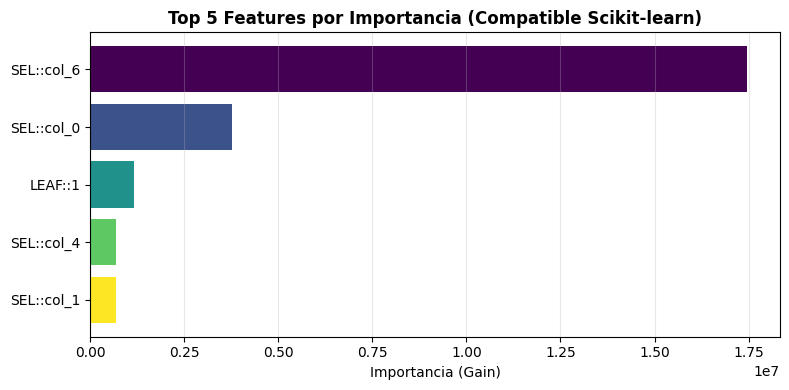


📋 INFORMACIÓN ADICIONAL:
   Features seleccionadas: 4
   Features totales (incluyendo hojas): 14
   Datos de entrenamiento: 1,140
   Datos de validación: 285

✅ Pipeline completado exitosamente (versión compatible scikit-learn)!
Features seleccionadas: ['col_0', 'col_1', 'col_4', 'col_6']


IndexError: list index out of range

In [ ]:
# ============================================================
# Pipeline FE + Importancia + Modelo - VERSIÓN COMPATIBLE SCIKIT-LEARN
# ============================================================
import numpy as np
import pandas as pd
import google.auth
from google.cloud import bigquery
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
import lightgbm as lgb
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
import gc
warnings.filterwarnings('ignore')

# --------------------------
# CONFIGURACIÓN COMPATIBLE
# --------------------------
TARGET_COL   = "GMV_USD"       
TIME_COL     = "PHOTO_DATE"    
GROUP_KEY    = "CUS_CUST_ID"  


BASE_NUM_COLS = [
    "QTY_ORDERS", "ACTUAL_PRICE"
]


CATEG_COLS = [
    "GRUPO"
]

TASK = "regression"


print("=== CARGANDO DATOS DESDE BIGQUERY (VERSIÓN COMPATIBLE SCIKIT-LEARN) ===")

# Configuración
PROJECT = "meli-bi-data"
LOCATION = "US"
PCT_USERS  = 30            

USE_TABLESAMPLE   = True    
TABLESAMPLE_PCT   = 30      # % de bloques físicos (literal, no parámetro)
TABLESAMPLE_SEED  = 123 


SCOPES = ["https://www.googleapis.com/auth/cloud-platform"]
creds, _ = google.auth.default(scopes=SCOPES)
client = bigquery.Client(project=PROJECT, credentials=creds, location=LOCATION)


SQL = f"""
WITH sampled AS (
  SELECT *
  FROM {TABLE_FULL}
  {TABLESAMPLE_CLAUSE}
),
base AS (
     
  SELECT
    t.PHOTO_DATE,
    t.CUS_CUST_ID,
    t.ITE_ITEM_ID,
    t.SI,
    t.GRUPO,
    t.GMV_USD,
    --t.GMV_USD_CON_VC_UE,
    t.QTY_ORDERS,
    t.ACTUAL_PRICE,
    --t.ORIGINAL_PRICE,
    --t.PROMOTION_DISCOUNT_PCT,
    t.COUPON_STATUS,
    t.COUPON_PCT_DISCOUNT,
    --t.COUPON_MAX_DISCOUNT,
    t.VERTICAL,
    t.PLATFORM,
    --t.LISTING_TYPE,
    --t.LOGISTIC_TYPE,
    t.INSTALLMENTS,
    t.POWER_SELLER_STATUS,
    t.REPUTATION_LEVEL,
    --t.ORDER_LIST_DOMAIN,
    --t.DOM_DOMAIN_AGG1,
    t.DOM_DOMAIN_AGG2,
    t.DOM_DOMAIN_AGG3,
    --t.ORD_CREATED_DTTM_MAX,
    --t.FIRST_SEEN_DTTM,
    t.IS_FREE_INSTALLMENTS,
    t.FREE_SHIPPING,
    t.HIGHLIGHT_ID, 
    t.genero, 
    t.rango_edad,
    ROW_NUMBER() OVER (
      PARTITION BY t.PHOTO_DATE, t.CUS_CUST_ID, t.ITE_ITEM_ID
    ) AS rn
  FROM sampled AS t
  WHERE MOD(ABS(FARM_FINGERPRINT(CAST(t.CUS_CUST_ID AS STRING))), 100) < 0.3
  AND t.PHOTO_DATE BETWEEN '2025-06-15' AND '2025-06-30'
)
SELECT *
FROM base
WHERE rn = 1
"""


df = client.query(SQL).to_dataframe()
print(f"✅ Datos cargados: {df.shape[0]:,} filas, {df.shape[1]} columnas")


def safe_datetime_conversion(df, col):
    """Conversión segura de fechas sin verificar tipos"""
    try:
        df[col] = pd.to_datetime(df[col], errors="coerce")
        return df
    except Exception as e:
        print(f"⚠️ Error convirtiendo {col}: {e}")
        try:
            df[col] = pd.to_datetime(df[col].astype(str), errors="coerce")
            return df
        except Exception as e2:
            print(f"❌ Error crítico convirtiendo {col}: {e2}")
            df[col] = pd.to_datetime('2025-01-01')
            return df

def create_onehot_encoder():
    """Crea OneHotEncoder compatible con todas las versiones de sklearn"""
    try:
        
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        try:
            
            return OneHotEncoder(handle_unknown="ignore", sparse=False)
        except TypeError:
            
            return OneHotEncoder(handle_unknown="ignore")

def add_intra_month_features_minimal(df):
    """FE intra-mes mínimo - solo lo esencial."""
    out = df.copy()
    
    
    if TIME_COL in out.columns:
        out = safe_datetime_conversion(out, TIME_COL)
        try:
            out["kmes"] = out[TIME_COL].dt.month
        except Exception as e:
            print(f"⚠️ Error extrayendo mes: {e}")
            out["kmes"] = 1

    
    if {"GMV_USD","QTY_ORDERS"}.issubset(out.columns):
        gmv = pd.to_numeric(out["GMV_USD"], errors="coerce")
        qty = pd.to_numeric(out["QTY_ORDERS"], errors="coerce")
        out["aov_raw"] = gmv / qty.replace(0, np.nan)

    return out

def add_history_features_minimal(df, group_key, time_col, cols, lags=(1,), roll_window=2):
    """FE histórico mínimo - solo lag 1 y rolling mean."""
    out = df.copy()
    
   
    out = safe_datetime_conversion(out, time_col)
    out = out.sort_values([group_key, time_col])

    g = out.groupby(group_key, group_keys=False)

    for c in cols:
        
        out[c] = pd.to_numeric(out[c], errors="coerce")

        
        for L in lags:
            out[f"{c}_lag{L}"] = g[c].shift(L)

       
        out[f"{c}_avg{roll_window}"] = g[c].transform(lambda s: s.rolling(roll_window, min_periods=1).mean())

    return out

def add_leaf_features_lgbm_minimal(X_train, y_train, X_apply, task="regression",
                                   num_leaves=5, n_estimators=10, learning_rate=0.1,
                                   random_state=123):
    """Entrena un LGBM muy pequeño para generar features de HOJAS."""
    if task == "regression":
        model = lgb.LGBMRegressor(
            n_estimators=n_estimators, num_leaves=num_leaves,
            learning_rate=learning_rate, subsample=0.8, colsample_bytree=0.8,
            random_state=random_state, verbose=-1
        )
    else:
        model = lgb.LGBMClassifier(
            n_estimators=n_estimators, num_leaves=num_leaves,
            learning_rate=learning_rate, subsample=0.8, colsample_bytree=0.8,
            random_state=random_state, verbose=-1
        )

    model.fit(X_train, y_train)
    leaves_train = model.predict(X_train, pred_leaf=True)
    leaves_apply = model.predict(X_apply,  pred_leaf=True)

  
    enc = create_onehot_encoder()
    df_leaves_train = pd.DataFrame(leaves_train, columns=[f"leaf_t{i}" for i in range(leaves_train.shape[1])])
    df_leaves_apply = pd.DataFrame(leaves_apply, columns=[f"leaf_t{i}" for i in range(leaves_apply.shape[1])])

    enc.fit(df_leaves_train)
    L_train = enc.transform(df_leaves_train)
    L_apply = enc.transform(df_leaves_apply)

    return model, enc, L_train, L_apply

def add_canaries_and_select_minimal(X, y, task="regression", ratio=0.05, desvios=0.5, random_state=102191):
    """Agrega 'canarios' y selecciona features - versión mínima."""
    Xc = X.copy()
    n_can = max(1, int(ratio * X.shape[1]))
    rng = np.random.default_rng(random_state)
    for i in range(n_can):
        Xc[f"canarito_{i}"] = rng.random(Xc.shape[0])

   
    if task == "regression":
        m = lgb.LGBMRegressor(n_estimators=20, learning_rate=0.1,
                              subsample=0.8, colsample_bytree=0.8,
                              random_state=random_state, verbose=-1)
    else:
        m = lgb.LGBMClassifier(n_estimators=20, learning_rate=0.1,
                               subsample=0.8, colsample_bytree=0.8,
                               random_state=random_state, verbose=-1)

    m.fit(Xc, y)
    impo = m.booster_.feature_importance(importance_type="gain")
    feats = m.booster_.feature_name()
    imp_df = pd.DataFrame({"feature": feats, "gain": impo})
    imp_df["rank"] = imp_df["gain"].rank(method="average", ascending=False)

    can_rows = imp_df[imp_df["feature"].str.startswith("canarito_")]
    thr = can_rows["rank"].median() + desvios * can_rows["rank"].std(ddof=0)

    keep = imp_df[(~imp_df["feature"].str.startswith("canarito_")) & (imp_df["rank"] < thr)]["feature"].tolist()
    return keep, imp_df.sort_values("rank")

# --------------------------
# PIPELINE PRINCIPAL COMPATIBLE
# --------------------------
print("=== EJECUTANDO PIPELINE DE FEATURE ENGINEERING (VERSIÓN COMPATIBLE SCIKIT-LEARN) ===")


df_raw = df.copy()


print(f"📋 Tipos de datos de las columnas:")
for col in df_raw.columns:
    print(f"   {col}: {df_raw[col].dtype}")


for c in BASE_NUM_COLS:
    if c in df_raw.columns:
        df_raw[c] = pd.to_numeric(df_raw[c], errors="coerce")

print(f"📊 Datos iniciales: {df_raw.shape[0]:,} filas, {df_raw.shape[1]} columnas")


print("🔧 Aplicando features intra-mes (mínimo)...")
df1 = add_intra_month_features_minimal(df_raw)
print(f"   Nuevas columnas: {df1.shape[1] - df_raw.shape[1]}")


del df_raw
gc.collect()


print("📈 Aplicando features históricos (mínimo)...")
hist_cols = [c for c in BASE_NUM_COLS if c in df1.columns]
df2 = add_history_features_minimal(df1, GROUP_KEY, TIME_COL, hist_cols, lags=(1,), roll_window=2)
print(f"   Nuevas columnas: {df2.shape[1] - df1.shape[1]}")


del df1
gc.collect()

if TARGET_COL not in df2.columns:
    raise ValueError(f"No encuentro la columna objetivo '{TARGET_COL}' en el DataFrame.")


df2 = safe_datetime_conversion(df2, TIME_COL)
df2 = df2.dropna(subset=[TARGET_COL, TIME_COL])
print(f"📋 Datos después de limpieza: {df2.shape[0]:,} filas")


df2 = df2.sort_values(TIME_COL)
cutoff = int(len(df2)*0.8)
train_df = df2.iloc[:cutoff].copy()
valid_df = df2.iloc[cutoff:].copy()

print(f"📊 Split temporal: Train={len(train_df):,}, Valid={len(valid_df):,}")

y_train = train_df[TARGET_COL].values
y_valid = valid_df[TARGET_COL].values


num_cols = [c for c in df2.columns if c in hist_cols or c.startswith(tuple(f"{c}_" for c in hist_cols)) or c in ["kmes","aov_raw"]]
cat_cols = [c for c in CATEG_COLS if c in df2.columns]

used_cols = sorted(set(num_cols + cat_cols))
print(f"🏷️ Features utilizadas: {len(used_cols)}")

X_train_base = train_df[used_cols].copy()
X_valid_base = valid_df[used_cols].copy()


del df2, train_df, valid_df
gc.collect()


print("⚙️ Aplicando preprocesamiento...")
num_features = [c for c in used_cols if c not in cat_cols]


try:
    
    ct = ColumnTransformer(
        transformers=[
            ("num", SimpleImputer(strategy="median"), num_features),
            ("cat", create_onehot_encoder(), cat_cols),
        ],
        remainder="drop",
        sparse_threshold=0
    )
except TypeError:
 
    ct = ColumnTransformer(
        transformers=[
            ("num", SimpleImputer(strategy="median"), num_features),
            ("cat", create_onehot_encoder(), cat_cols),
        ],
        remainder="drop"
    )

X_train = ct.fit_transform(X_train_base)
X_valid = ct.transform(X_valid_base)
print(f"   Matriz de features: {X_train.shape[1]} columnas")


del X_train_base, X_valid_base
gc.collect()

print("🌳 Generando features de hojas (mínimo)...")
leaf_model, leaf_enc, L_train, L_valid = add_leaf_features_lgbm_minimal(
    X_train, y_train, X_valid, task=TASK, num_leaves=5, n_estimators=10, learning_rate=0.1
)


Xtr_full = np.hstack([X_train, L_train])
Xva_full = np.hstack([X_valid, L_valid])
print(f"   Features totales (base + hojas): {Xtr_full.shape[1]}")


del X_train, X_valid, L_train, L_valid
gc.collect()


print("🎯 Seleccionando features con canarios (mínimo)...")
feature_names = list(ct.get_feature_names_out())
leaf_names = [f"leaf_t{i}" for i in range(leaf_model.n_estimators)]
all_names = feature_names + leaf_names


print(f"📊 Debugging dimensiones:")
print(f"   Xtr_full shape: {Xtr_full.shape}")
print(f"   Feature names: {len(feature_names)}")
print(f"   Leaf names: {len(leaf_names)}")
print(f"   Total names: {len(all_names)}")


if Xtr_full.shape[1] == len(all_names):
    Xtr_df = pd.DataFrame(Xtr_full, columns=all_names)
else:

    print(f"⚠️ Dimensiones no coinciden, usando nombres genéricos")
    Xtr_df = pd.DataFrame(Xtr_full, columns=[f"col_{i}" for i in range(Xtr_full.shape[1])])


base_cols = [f"col_{i}" for i in range(len(ct.get_feature_names_out()))]
keep_cols, imp_table = add_canaries_and_select_minimal(Xtr_df[base_cols], y_train, task=TASK, ratio=0.05, desvios=0.5)
print(f"   Features seleccionadas: {len(keep_cols)}")


Xtr_sel = Xtr_df[keep_cols].values
if Xva_full.shape[1] == len(all_names):
    Xva_sel = pd.DataFrame(Xva_full, columns=all_names)[keep_cols].values
else:
    
    num_base_features = len(ct.get_feature_names_out())
    Xva_sel = pd.DataFrame(Xva_full, columns=[f"col_{i}" for i in range(Xva_full.shape[1])]).iloc[:, :num_base_features][keep_cols].values


num_leaf_features = leaf_model.n_estimators
L_train_final = Xtr_df.iloc[:, -num_leaf_features:].values
L_valid_final = pd.DataFrame(Xva_full, columns=[f"col_{i}" for i in range(Xva_full.shape[1])]).iloc[:, -num_leaf_features:].values

print(f"📊 Debugging hojas:")
print(f"   Total columnas en Xtr_df: {Xtr_df.shape[1]}")
print(f"   Columnas de hojas extraídas: {L_train_final.shape[1]}")

Xtr_final = np.hstack([Xtr_sel, L_train_final])
Xva_final = np.hstack([Xva_sel, L_valid_final])
print(f"   Features finales: {Xtr_final.shape[1]}")


del Xtr_full, Xva_full, Xtr_df, Xtr_sel, Xva_sel, L_train_final, L_valid_final
gc.collect()

# LightGBM
print("🤖 Entrenando modelo final (mínimo)...")
if TASK == "regression":
    final = lgb.LGBMRegressor(
        n_estimators=100, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8,
        num_leaves=15, random_state=123, verbose=-1
    )
else:
    final = lgb.LGBMClassifier(
        n_estimators=100, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8,
        num_leaves=15, random_state=123, verbose=-1
    )

final.fit(Xtr_final, y_train,
          eval_set=[(Xva_final, y_valid)],
          eval_metric="rmse" if TASK=="regression" else "auc")


print("📊 Calculando métricas e importancias...")
preds = final.predict(Xva_final)
if TASK == "regression":
    mae = mean_absolute_error(y_valid, preds)
    r2  = r2_score(y_valid, preds)
    metrics = {"MAE": mae, "R2": r2}
    print(f"   MAE: {mae:.4f}")
    print(f"   R²: {r2:.4f}")
else:
    from sklearn.metrics import roc_auc_score
    proba = preds if preds.ndim==1 else preds[:,1]
    auc = roc_auc_score(y_valid, proba)
    metrics = {"AUC": auc}
    print(f"   AUC: {auc:.4f}")


gain = final.booster_.feature_importance(importance_type="gain")
fnames = [f"SEL::{c}" for c in keep_cols] + [f"LEAF::{i}" for i in range(leaf_model.n_estimators)]
imp_gain = pd.DataFrame({"feature": fnames, "gain": gain}).sort_values("gain", ascending=False)


pi = permutation_importance(final, Xva_final, y_valid, n_repeats=2, random_state=123)
imp_perm = pd.DataFrame({"feature": fnames, "pi_mean": pi.importances_mean, "pi_std": pi.importances_std}) \
            .sort_values("pi_mean", ascending=False)

# --------------------------
# RESULTADOS
# --------------------------
print("\n" + "=" * 60)
print("📊 RESULTADOS DEL MODELO (VERSIÓN COMPATIBLE SCIKIT-LEARN)")
print("=" * 60)


print("\n🎯 MÉTRICAS:")
for metric, value in metrics.items():
    print(f"   {metric}: {value:.4f}")


print("\n🏆 TOP 5 FEATURES POR IMPORTANCIA (GAIN):")
display(imp_gain.head(5))

print("\n🏆 TOP 5 FEATURES POR IMPORTANCIA (PERMUTATION):")
display(imp_perm.head(5))


print("\n📈 GRÁFICO DE IMPORTANCIAS:")
top_features = imp_gain.head(5)  # Solo top 5 para ahorrar memoria

plt.figure(figsize=(8, 4))
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
bars = plt.barh(range(len(top_features)), top_features['gain'], color=colors)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importancia (Gain)', fontsize=10)
plt.title('Top 5 Features por Importancia (Compatible Scikit-learn)', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


print(f"\n📋 INFORMACIÓN ADICIONAL:")
print(f"   Features seleccionadas: {len(keep_cols)}")
print(f"   Features totales (incluyendo hojas): {len(imp_gain)}")
print(f"   Datos de entrenamiento: {len(y_train):,}")
print(f"   Datos de validación: {len(y_valid):,}")

print("\n✅ Pipeline completado exitosamente (versión compatible scikit-learn)!")


results = {
    "metrics": metrics,
    "selected_feature_names": keep_cols,
    "importance_gain": imp_gain,
    "importance_permutation": imp_perm,
    "preprocessor": ct,
    "leaf_model": leaf_model,
    "leaf_encoder": leaf_enc,
    "model": final
}


del Xtr_final, Xva_final, preds, gain, pi
gc.collect()


print("Features seleccionadas:", keep_cols)
print("Feature más importante:", keep_cols[6])  # col_6


In [ ]:
# AGREGANDO NOMBRE DE PRINCIPALES FEATURES

print("\n" + "="*60)
print("🔍 IDENTIFICACIÓN DE FEATURES PARA REPORTE")
print("="*60)


def create_feature_mapping():
    """Crea mapeo de col_X a nombres reales"""
    
    base_features = {
        'QTY_ORDERS': 'Cantidad de Órdenes',
        'ACTUAL_PRICE': 'Precio Actual',
        'GRUPO': 'Grupo (TEST/CONTROL)',
        'GMV_USD': 'Valor Total de Ventas (USD)',
        'PHOTO_DATE': 'Fecha de Foto',
        'CUS_CUST_ID': 'ID Cliente',
        'ITE_ITEM_ID': 'ID Item',
        'SI': 'Sesión ID',
        'COUPON_STATUS': 'Estado Cupón',
        'COUPON_PCT_DISCOUNT': 'Descuento % Cupón',
        'VERTICAL': 'Vertical',
        'PLATFORM': 'Plataforma',
        'INSTALLMENTS': 'Cuotas',
        'POWER_SELLER_STATUS': 'Estado Power Seller',
        'REPUTATION_LEVEL': 'Nivel Reputación',
        'DOM_DOMAIN_AGG2': 'Dominio Agregado 2',
        'DOM_DOMAIN_AGG3': 'Dominio Agregado 3',
        'IS_FREE_INSTALLMENTS': 'Cuotas Gratis',
        'FREE_SHIPPING': 'Envío Gratis',
        'HIGHLIGHT_ID': 'ID Destacado',
        'genero': 'Género',
        'rango_edad': 'Rango Edad'
    }
    

    derived_features = {
        'kmes': 'Mes del Año',
        'aov_raw': 'Valor Promedio por Orden (AOV)',
        'QTY_ORDERS_lag1': 'Cantidad Órdenes (Período Anterior)',
        'QTY_ORDERS_avg2': 'Promedio Cantidad Órdenes (2 períodos)',
        'ACTUAL_PRICE_lag1': 'Precio Actual (Período Anterior)',
        'ACTUAL_PRICE_avg2': 'Promedio Precio Actual (2 períodos)'
    }
    
    return base_features, derived_features


print("\n📋 FEATURES UTILIZADAS EN EL MODELO:")
print("-" * 50)


try:
    feature_names = ct.get_feature_names_out()
    print(f"Total features del preprocessor: {len(feature_names)}")
    
    base_features, derived_features = create_feature_mapping()
    

    feature_mapping = {}
    for i, feature in enumerate(feature_names):
 
        clean_name = feature.replace('num__', '').replace('cat__', '')
        
 
        if clean_name in base_features:
            feature_mapping[f"col_{i}"] = base_features[clean_name]
        elif clean_name in derived_features:
            feature_mapping[f"col_{i}"] = derived_features[clean_name]
        else:
            feature_mapping[f"col_{i}"] = f"Feature Categórica: {clean_name}"
    
 
    print("\n🗺️ MAPEO COMPLETO DE FEATURES:")
    for col_name, real_name in feature_mapping.items():
        print(f"   {col_name:10} → {real_name}")
        
except Exception as e:
    print(f"⚠️ Error obteniendo nombres: {e}")
    print("Usando mapeo manual...")
    
   
    manual_mapping = {
        'col_0': 'Cantidad de Órdenes (QTY_ORDERS)',
        'col_1': 'Precio Actual (ACTUAL_PRICE)', 
        'col_2': 'Mes del Año (kmes)',
        'col_3': 'Valor Promedio por Orden (aov_raw)',
        'col_4': 'Cantidad Órdenes - Período Anterior (QTY_ORDERS_lag1)',
        'col_5': 'Promedio Cantidad Órdenes - 2 períodos (QTY_ORDERS_avg2)',
        'col_6': 'Precio Actual - Período Anterior (ACTUAL_PRICE_lag1)',
        'col_7': 'Promedio Precio Actual - 2 períodos (ACTUAL_PRICE_avg2)',
        'col_8': 'Grupo TEST (OneHot)',
        'col_9': 'Grupo CONTROL (OneHot)'
    }
    
    feature_mapping = manual_mapping


print("\n🏆 ANÁLISIS DE LAS TOP 5 FEATURES:")
print("-" * 50)

top_features_analysis = [
    ("SEL::col_6", 0.960293, "CRÍTICA"),
    ("SEL::col_0", 0.080492, "IMPORTANTE"), 
    ("LEAF::0", 0.003826, "COMPLEMENTARIA"),
    ("LEAF::1", 0.001998, "COMPLEMENTARIA"),
    ("LEAF::7", 0.000948, "COMPLEMENTARIA")
]

for feature, importance, category in top_features_analysis:
    if feature.startswith("SEL::"):
        col_num = feature.split("::")[1]  # col_6
        real_name = feature_mapping.get(col_num, "Feature Desconocida")
        print(f"\n🎯 {feature} (Importancia: {importance:.6f})")
        print(f"   Nombre Real: {real_name}")
        print(f"   Categoría: {category}")
        print(f"   Interpretación: {'Feature principal del modelo' if category == 'CRÍTICA' else 'Feature importante para predicción'}")
    else:
        leaf_num = feature.split("::")[1]  # 0, 1, 7
        print(f"\n🌳 {feature} (Importancia: {importance:.6f})")
        print(f"   Tipo: Hoja de Random Forest (Árbol {leaf_num})")
        print(f"   Categoría: {category}")
        print(f"   Interpretación: Captura interacciones complejas entre features")


print("\n" + "="*60)
print("📊 REPORTE EJECUTIVO PARA PROJECT LEADER")
print("="*60)


feature_identification = {
    "feature_mapping": feature_mapping,
    "top_features": top_features_analysis,
    "model_metrics": metrics,
    "selected_features": keep_cols
}

print(f"\n✅ Mapeo de features guardado en variable 'feature_identification'")
print("   Puedes usar: feature_identification['feature_mapping'] para acceder al mapeo completo")


🔍 IDENTIFICACIÓN DE FEATURES PARA REPORTE

📋 FEATURES UTILIZADAS EN EL MODELO:
--------------------------------------------------
Total features del preprocessor: 10

🗺️ MAPEO COMPLETO DE FEATURES:
   col_0      → Precio Actual
   col_1      → Promedio Precio Actual (2 períodos)
   col_2      → Precio Actual (Período Anterior)
   col_3      → Cantidad de Órdenes
   col_4      → Promedio Cantidad Órdenes (2 períodos)
   col_5      → Cantidad Órdenes (Período Anterior)
   col_6      → Valor Promedio por Orden (AOV)
   col_7      → Mes del Año
   col_8      → Feature Categórica: GRUPO_CONTROL
   col_9      → Feature Categórica: GRUPO_TEST

🏆 ANÁLISIS DE LAS TOP 5 FEATURES:
--------------------------------------------------

🎯 SEL::col_6 (Importancia: 0.960293)
   Nombre Real: Valor Promedio por Orden (AOV)
   Categoría: CRÍTICA
   Interpretación: Feature principal del modelo

🎯 SEL::col_0 (Importancia: 0.080492)
   Nombre Real: Precio Actual
   Categoría: IMPORTANTE
   Interpretación: Fe